# Exercise: 1D Burgers Equation

The Cauchy Problem to be solved is the Burgers Equation 
\begin{align}
&\partial_t u (x,t) + u \partial_x u (x,t) - \nu \partial_x^2 u (x,t) = 0 \\
&u(t=0, x) = - \sin \left( \pi \, x \right) \\
&u\left(t, x=\pm 1\right) =  0
\end{align}
with $(t,x) \in [0,1] \times [-1, +1]$, and where we set
$$
\nu = \frac{0.01}{\pi}
$$


------
Extra: reviews on PINN

[1] https://www.nature.com/articles/s42254-021-00314-5

[2] https://arxiv.org/pdf/2202.06416.pdf

[3] https://www.mdpi.com/2504-2289/6/4/140

[4] https://medium.com/@vignesh.g1609/pinn-physics-informed-neural-networks-5f5f05bf7231

[5] https://ocw.mit.edu/courses/18-152-introduction-to-partial-differential-equations-fall-2011/29c6f7ee914a1d804899781f9f604f49_MIT18_152F11_lec_24.pdf , https://ocw.mit.edu/courses/18-152-introduction-to-partial-differential-equations-fall-2011/download/

In [1]:
# Find GPU in this environment
import os, subprocess, re
os.environ["CUDA_VISIBLE_DEVICES"] = ''.join(re.findall("UUID: (MIG-[^)]+)\)", str(subprocess.check_output(["nvidia-smi", "-L"]), 'ascii')))

In [2]:
from typing import Type, Union
import gc
import tqdm
import math
from collections import OrderedDict
try:
    import tqdm
except:
    %pip install tqdm
    import tqdm

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
import matplotlib.pyplot as plt

Device: cuda:0


## 1. Define a DNN as torch module

In [3]:
class PINN_DNN(nn.Module):
    """
    Basic Deep Neural Network
    """
    def __init__(
        self,
        n_inputs : int,      # number of inputs, e.g. x,y,z,t,....
        n_outputs: int,      # number of outputs, e.g. u,v,P, T, ....
        hidden_dims: list,   # number of hidden layers
        dropout: float = 0.2,# Dropout
        activation_func = nn.ReLU(), # activation function hidden layers
    ):
        super(PINN_DNN, self).__init__()
        self.n_layers = len(hidden_dims)
        self.dropout_prob = dropout
        self.activation_func = activation_func

        layers = OrderedDict()
        for i in range(self.n_layers):
            # Input layer
            if i == 0:
                layers[f"fc{i}"] = nn.Linear(n_inputs, hidden_dims[0], bias=False)
            # Hidden Layer(s)
            else:
                layers[f"fc{i}"] = nn.Linear(hidden_dims[i-1], hidden_dims[i], bias=False)
            layers[f"act_{i}"]   = self.activation_func
            layers[f"dropout_{i}"] = nn.Dropout(p=self.dropout_prob)

        # Output Layers
        layers[f"fc_{i+1}"] = nn.Linear(hidden_dims[-1], n_outputs, bias=True)

        self.network = nn.Sequential(layers)
        self.reset_parameters()

    def reset_parameters(self):
        """
        Initialisation method for the DNN layers weights (and biases)
        """
        for layer in self.network:
            if not isinstance(layer, nn.Linear):
                continue
            nn.init.normal_(layer.weight, std=1 / math.sqrt(layer.out_features) )
            if layer.bias is not None:
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(layer.weight)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(layer.bias, -bound, bound)

    def forward(self, x):
        return self.network(x)

## 2. Define the PDE class with torch.autograd

In [4]:
class Burgers_1D_PDE:
    """
        Class computing the 1D Burgers PDE equation:
            u_t + u u_x - ν u_xx = 0
        Notice that we can conveniently rewrite it as
            u_t + (1/2)*(u**2)_x- ν u_xx = 0

        --------------------------
        Args:
            nu    (float): Float parameter describing the diffusion term

        Methods:
            compute_heat      (coords, pred_funcs): returns the computed Heat eq.
    """
    def __init__(
        self,
        nu: float = float(0.01/np.pi),     # PDE coefficient
    ):
        self.nu = nu

    def compute_burgers(self, coords: torch.Tensor, pred_func: torch.Tensor) -> torch.Tensor:
        """
        Compute 1D Heat equation
            u_t + (u**2)_x/2 - ν u_xx
        It should equate to zero.

        Args:
            coords    (torch.Tensor): (t,x) coords.
            pred_func (torch.Tensor): (u) evaluated at (t,x)
        """
        u = pred_func[:,0]
        # compute derivatives
        u_t  = self.get_derivative(pred_func, coords, 1)[:,0]

        u_x  = self.get_derivative(pred_func, coords, 1)[:,1]
        u_xx = self.get_derivative(u_x, coords, 1)[:,1]
        
        u2_x = self.get_derivative(pred_func.pow(2), coords, 1)[:,1]/2

        # return evaluated PDE
        return u_t + u2_x - (self.nu) * u_xx

    def get_derivative(self, y, x, n: int = 1):
        """
        General formula to compute the n-th order derivative of y = f(x) with respect to x
        """
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y).to(y.device), create_graph=True, retain_graph=True, allow_unused=True)[0]
        return self.get_derivative(dy_dx, x, n - 1)

### 2.0 test the PDE class

In [5]:
"""
    Test the Burgers_1D_PDE class
"""
nu_param = float(0.01/np.pi)

test_pde  = Burgers_1D_PDE(nu=nu_param)
model_try = PINN_DNN(n_inputs=2, n_outputs=1, hidden_dims=[4,8,4])

N_POINTS = 10000
coords = torch.cat( (
    torch.rand(N_POINTS).unsqueeze(-1),        # t
    2*torch.rand(N_POINTS).unsqueeze(-1) - 1), # x
    dim=-1
)
X = Variable(coords, requires_grad=True)
pred_func = model_try(X)

heat_pred = test_pde.compute_burgers(X, pred_func)

print(f"Pred: {heat_pred.mean()}")

Pred: -0.03470451757311821


## 3. Boundary Conditions

In [6]:
class Burgers_1D_BC:
    def __init__(
        self,
        cost_function = nn.MSELoss()
    ):
        # Cost function
        self.cost_function = cost_function

    def boundary_cond(self, coords: torch.Tensor, pred_func: torch.Tensor) -> torch.Tensor:
        """
        Class for computing BC
            u(t, x=±1) = 0

        Args:
             coords    (torch.Tensor) : The coords at the spatial boundary
             pred_func (torch.Tensor) : The predicted function at those points
        Returns
             bc_loss (torch.tensor)
        """
        true_b  = torch.zeros_like(pred_func)
        bc_loss = self.cost_function(pred_func, true_b)

        return torch.mean( bc_loss )

    def initial_cond(self, coords: torch.Tensor, pred_func: torch.Tensor) -> torch.Tensor:
        """
        Class for computing IC
            u(x, t=0) = - sin(π x)

        Args:
             coords    (torch.Tensor) : The coords at the Initial Time
             pred_func (torch.Tensor) : The predicted function at those points
        Returns
             ic_loss (torch.tensor)
        """
        pi_fact = float(torch.pi)
        x = coords[:, 1].detach().cpu().numpy()
        true_b  = - np.sin(pi_fact * x)

        ic_loss = self.cost_function(pred_func,  torch.tensor(true_b, requires_grad=False).unsqueeze(-1).to(pred_func.device))

        return torch.mean( ic_loss )

### 3.0 Test Boundary Class

Pred Initial Condition: 3.371793846953646e-16

Pred Boundary Condition: 0.01088593527674675


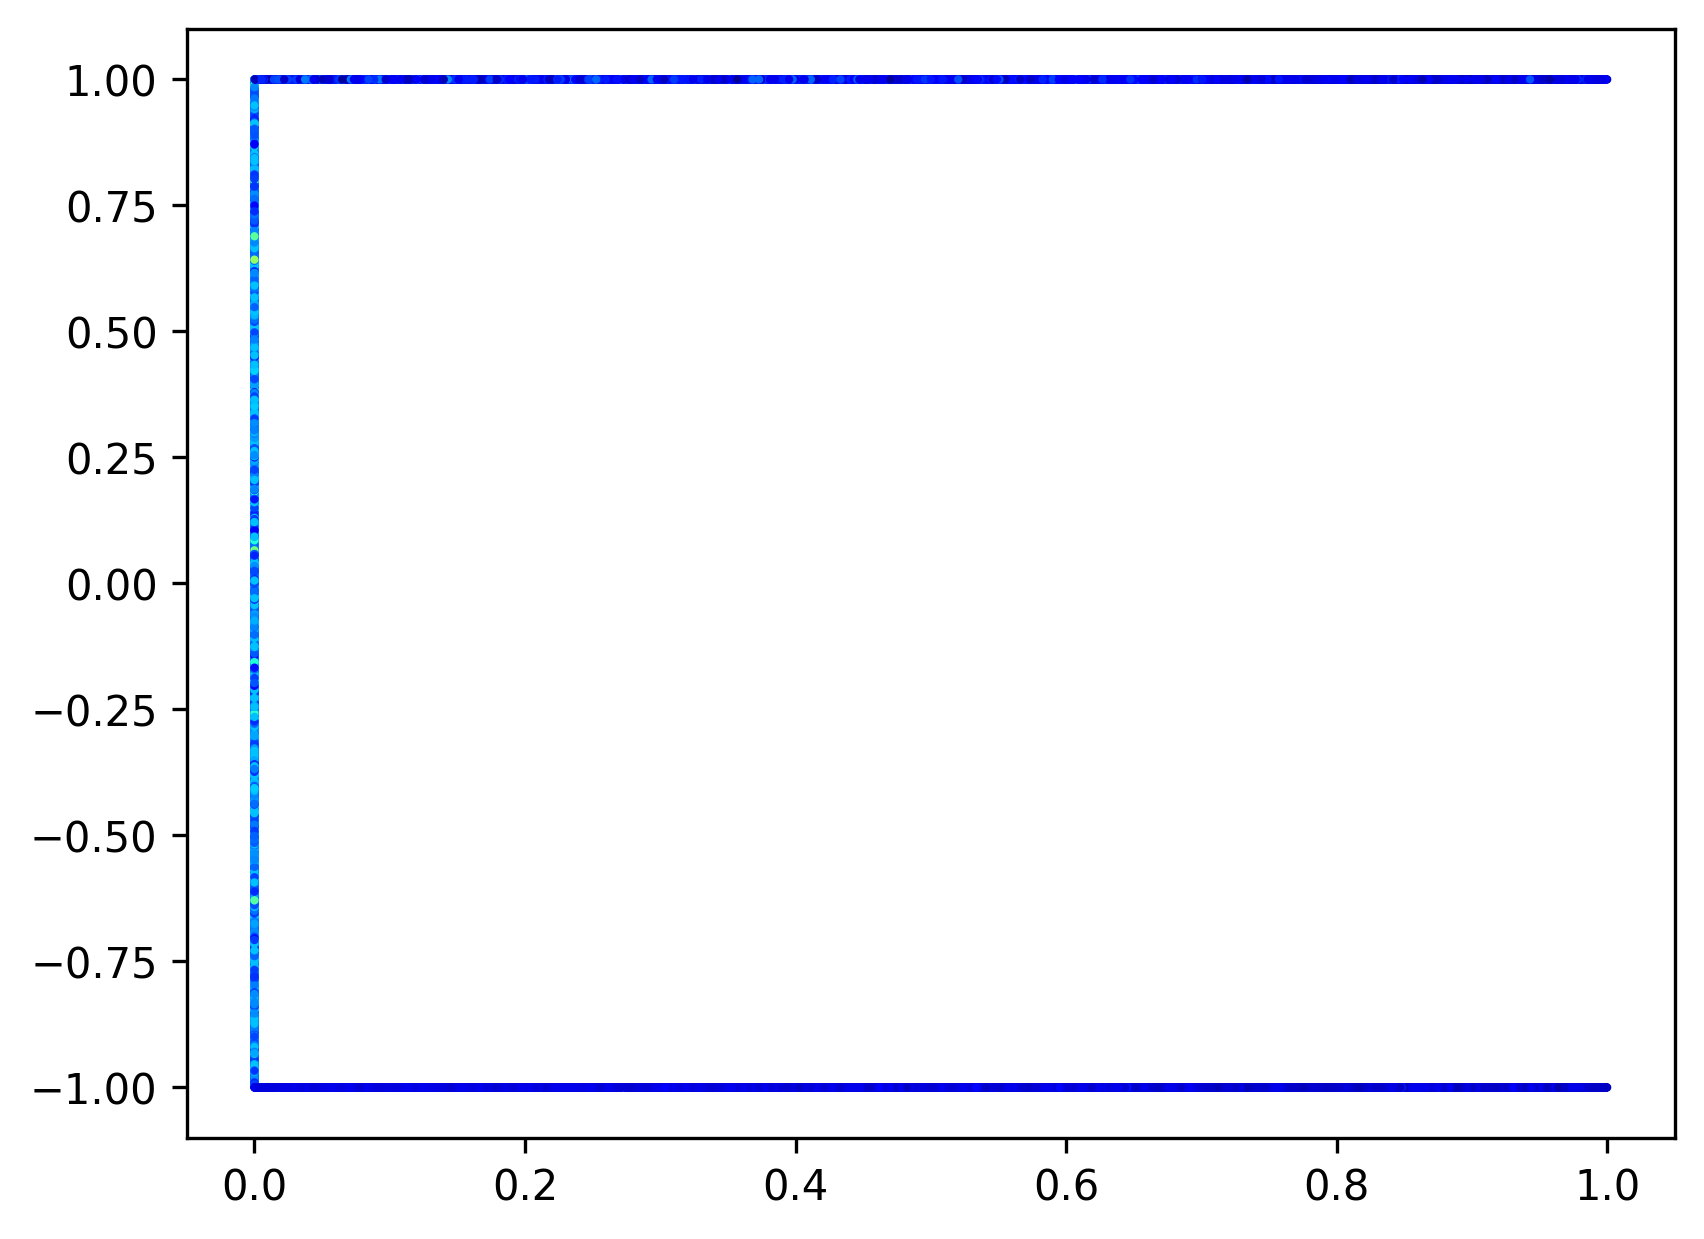

In [7]:
"""
    Test the BC_PDE class
"""

test_bc   = Burgers_1D_BC()
model_try = PINN_DNN(n_inputs=2, n_outputs=1, hidden_dims=[4,8,4])

N_POINTS = 10000
ic_coords = torch.cat( (
      torch.zeros(N_POINTS).unsqueeze(-1),      # t
      2*torch.rand(N_POINTS).unsqueeze(-1) - 1  # x
    ),
    dim=-1
)

X = Variable(ic_coords, requires_grad=True)
pred_func_ic = - torch.sin(np.pi * X)[:,1].unsqueeze(-1) #model_try(X)

heat_ic_pred = test_bc.initial_cond(X, pred_func_ic)

print(f"Pred Initial Condition: {heat_ic_pred}\n")


bc_coords_p = torch.cat( (
      torch.rand(N_POINTS//2).unsqueeze(-1), # t
      +torch.ones(N_POINTS//2).unsqueeze(-1)  # x
    ),
    dim=-1
)
bc_coords_m = torch.cat( (
      torch.rand(N_POINTS//2).unsqueeze(-1), # t
      -torch.ones(N_POINTS//2).unsqueeze(-1)  # x
    ),
    dim=-1
)
bc_coords = torch.cat([bc_coords_p, bc_coords_m])
X = Variable(bc_coords, requires_grad=True)
pred_func_bc = model_try(X)
heat_bc_pred = test_bc.boundary_cond(X, pred_func_bc)

print(f"Pred Boundary Condition: {heat_bc_pred}")

plt.figure(dpi=300)
plt.scatter( ic_coords[:, 0], ic_coords[:, 1], c=pred_func_bc.detach().squeeze().cpu(), s=1, cmap='jet' )
plt.scatter( bc_coords[:, 0], bc_coords[:, 1], c=pred_func_bc.detach().squeeze().cpu(), s=1, cmap='jet', vmin=0, vmax=1 )
plt.show()

In [8]:
X = Variable(ic_coords, requires_grad=True)

test_pde.get_derivative(- torch.sin(np.pi * X), X, 1)[:,1] + np.pi* torch.cos(np.pi * X[:,1])

test_pde.get_derivative( 
    test_bc.initial_cond(
        X, - torch.sin(np.pi * X[:,1]).unsqueeze(-1)
    ), X
)

tensor([[ 0.0000e+00, -0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -0.0000e+00],
        [ 0.0000e+00, -2.8915e-11]], grad_fn=<SliceBackwardBackward0>)

## 4. Assemble PINN model

#### Soft Adapt:

Here we have a total loss which is a weighted sum of multiple terms:
$$\mathcal{L} = w_{rec} \mathcal{L}_{rec} (u, u_{t}) + w_{pde} \mathcal{L}_{pde} (u_t) + w_{bc} \mathcal{L}_{bc} (u_t)$$

The idea of SoftAdapt is to see the $w=w(i)$ as function of the epoch $i$; let us say $a = {rec, pde, bc}$. Then
$$w_a (i) = \text{softmax} \left[ \frac{L_a (i)}{L_a (i-1) +\epsilon} - \mu(i)   \right]$$
where $L_a(i)$ is the $a-$loss at epoch $i$, $\epsilon$ a small parameter to prevend division by zero, and
$$\mu(i) = \max_a \frac{L_a (i)}{L_a (i-1)}$$

#### Learning rate annealing:

$$\mathcal{L} \supseteq \mathcal{L}_{pde} (u_t) + w_{bc} \mathcal{L}_{bc} (u_t)$$

we can have a dynamical $w_{bc}$ obtained by an exponential moving average, controlled by an hyperparameter $\alpha$; in fact, we first compute

$$\bar w = \frac{\max |\nabla_\theta \mathcal{L}_{pde} (\theta) |}{ \text{mean} |\nabla_\theta \mathcal{L}_{bc} (\theta) |}$$
where $\theta$ indicates the set of DNN model parameters; then, the $w_{bc} (i)$ is given by
$$w_{bc} (i) = \alpha \bar w + (1-\alpha) w_{bc} (i-1)$$

--------------
Refs:

[1] https://towardsdatascience.com/improving-pinns-through-adaptive-loss-balancing-55662759e701 , https://github.com/rbischof/relative_balancing , https://arxiv.org/abs/2110.09813

[2] https://docs.nvidia.com/deeplearning/modulus/modulus-v2209/user_guide/theory/advanced_schemes.html#softadapt , original paper: https://arxiv.org/pdf/1912.12355.pdf

[3] https://docs.nvidia.com/deeplearning/modulus/modulus-v2209/user_guide/theory/advanced_schemes.html#learning-rate-annealing . original paper https://arxiv.org/pdf/2001.04536.pdf



In [9]:
import json

def write_line_to_file(LOG_FILE: str, log_line: str):
    with open(LOG_FILE, 'a') as f:
        f.write(log_line)

def store_hyp_dict(json_file: str, hyperparam_kwargs: dict, _indent: int = 4):
    with open(json_file, 'w') as fp:
        json.dump(hyperparam_kwargs, fp, indent=_indent)

In [10]:
# Checkpoints (to save model parameters during training)
# this is implemented by writing a python class that uses the torch.save method
class SaveBestModel:
    def __init__(
        self,
        model_name: str = 'best_model',
        best_valid_loss=float('inf')
    ): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        self.model_name = model_name

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch}\n")
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f'{self.model_name}.pth')

In [11]:
import datetime
import time

class PINN(nn.Module):
    """
    Full PINN Class for the FORWARD problem.

    It incorporates:
        1. The PINN DNN (in self.DNN)
        2. The PDE      (in self._PDE)
        3. The BC       (in self._BC)

    It exposes the train_model() method to solve the PINN forward problem, by Performing a training with ADAM optimiser

    The train_model() method is thus:
        1. ADAM loop
            1.1. call training_step() for adam
            1.2. Store best model
            1.3. Perform step for learning rate stepper
            1.4. Logs
            1.5. Check if patience reached;

    Args:
        For Args see init method.

    Methods:
        init_model      ()  : init the model.
        load_best_model ()  : reload the best model.
        forward         (x) : DNN Forward passing
        pde_loss        (x, pred_funcs) : Compute PDE loss using self.cost_function
        ic_loss         (x, pred_funcs) : Compute IC  loss using BC class
        bc_loss         (x, pred_funcs) : Compute BC  loss using BC class
        soft_adapt      (losses, previous_losses, eps = 1e-8) : perform SoftAdapt algorithm.
        generate_coords ()  : generate the coords
        closure         ()  : method performing the backprop. Fundamental for L-BFGS part, it is also used for ADAM.
        training_step   (epoch, use_adam)   : Single training step.
        train_model     ()  : Main method. Trains the model.
        store_training_df   ()  : utils method to store the training history as csv
    """
    def __init__(
        self,
        use_rec: bool = True, # parameter to flag False if PINN solve PDE without reconstruction info
        # DNN
        n_inputs : int = 2,      # number of inputs, e.g. x,y,z,t,....
        n_outputs: int = 1,      # number of outputs, e.g. u,v,P, T, ....
        hidden_layers: list = [4, 8, 16, 8], # number of hidden layers
        dropout: float = 0.2,  # Dropout
        activation_func = nn.Tanh(),
        learning_rate: float = 0.001,
        # True func
        exact_solution_func = lambda x: x,
        # Geometry
        time_interval : list = [0.0,  +1.0] ,
        space_interval: list = [-1.0, +1.0] ,
        # PDE
        diffusion_coefficient: float = float(0.01/np.pi),     # PDE coefficient
        # Training
        patience_training: int = 200,
        epochs: int = 1000,
        N_batches: int = 32,
        patience_lr: int = 50,
        # Soft adapt
        use_softadapt : bool = False,
        softadapt_starting_epoch : int = 5,
        # Loss weights
        weight_rec: float = 1.0,
        weight_pde: float = 1.0,
        weight_bc : float = 1.0,
        weight_ic : float = 1.0,
        # dataloaders
        fun_batch_size: int = 4096,
        pde_batch_size: int = 4096,
        bc_batch_size: int = 1024,
        ic_batch_size: int = 1024,
        # device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
        # Model name
        BASE_PATH_TO_STORE: str = '.',
        model_name: str = 'pinne_heat',
    ):
        """
        Init method.

        Args:
            use_rec     (bool, optional)    : Boolean to pick if rec_loss should be used. Defaults to True.
            n_inputs    (int, optional)     : Number of DNN inputs. Defaults to 2.
            n_outputs   (int, optional)     : Number of DNN outputs. Defaults to 1.
            hidden_layers (list, optional)  : Listof hidden layers dims. Defaults to [4, 8, 16, 8].
            learning_rate (float, optional) : Adam Learning rate. Defaults to 0.001.
            exact_solution_func     (function, optional): Method to generate the exact solution. Defaults to exact_solution_func.
            diffusion_coefficient   (float, optional)   : Heat diffusion coefficient. Defaults to 0.01/π.
            patience_training       (int, optional)     : Patience in ADAM training. Defaults to 200.
            epochs                  (int, optional)     : Total Number of ADAM epochs. Defaults to 1000.
            N_batches               (int, optional)     : Number of ADAM Batches. Defaults to 32.
            patience_lr             (int, optional)     : Patience for LR stepper. Defaults to 50.
            use_softadapt            (bool, optional) : Boolean to decide whether to use SoftAdapt algorithm. Defaults to True,
            softadapt_starting_epoch (int, optional)  : SoftAdapt starting epoch. Defaults to 5.
            weight_rec  (float, optional)   : Reconstruction Loss weight. Defaults to 1.0.
            weight_pde  (float, optional)   : PDE Loss weight. Defaults to 1.0.
            weight_bc   (float, optional)   : BC Loss weight. Defaults to 1.0.
            weight_ic   (float, optional)   : IC Loss weight. Defaults to 1.0.
            fun_batch_size  (int, optional) : Batch Size for computing rec loss. Defaults to 4096.
            pde_batch_size  (int, optional) : Batch Size for computing pde loss. Defaults to 4096.
            bc_batch_size   (int, optional) : Batch Size for computing bc  loss. Defaults to 1024.
            device      (_type_, optional)  : Device. Defaults to torch.device("cuda:0" if torch.cuda.is_available() else "cpu").
            BASE_PATH_TO_STORE  (str, optional) : Path to store training and model data. Defaults to '.'.
            model_name          (str, optional) : Model name. Defaults to 'pinne_heat'.
        """
        super(PINN, self).__init__()
        self.use_rec = use_rec
        # geometry
        self._t_min , self._t_max = time_interval
        self._x_min , self._x_max = space_interval
        # ==== DNN PART ==================
        self.n_inputs      = n_inputs
        self.n_outputs     = n_outputs
        self.hidden_layers = hidden_layers
        self.n_layers      = len(hidden_layers)
        self.dropout_prob  = dropout
        self.activation_func = activation_func
        self.learning_rate = learning_rate
        self.device = device
        # ==== SoftAdapt PART ==================
        self.use_softadapt = use_softadapt
        self.softadapt_starting_epoch = softadapt_starting_epoch if softadapt_starting_epoch >= 2 else 2
        # ====  PDE params PART ==================
        self.diffusion_coefficient = diffusion_coefficient
        self.exact_solution_func   = exact_solution_func

        # ==== PINN-DNN PART ==================
        # Dataloader
        self.fun_batch_size = fun_batch_size
        self.pde_batch_size = pde_batch_size
        self.ic_batch_size  = ic_batch_size
        self.bc_batch_size  = bc_batch_size
        self.N_batches   = N_batches
        # training vars
        self.patience_training = patience_training
        self.epochs = epochs
        self.patience_lr     = patience_lr
        # Loss weights
        self.weight_rec = weight_rec
        self.weight_pde = weight_pde
        self.weight_bc  = weight_bc
        self.weight_ic  = weight_ic
        # DNN
        self.model_kwargs = {
           "n_inputs"     : self.n_inputs,
            "n_outputs"   : self.n_outputs,
            "hidden_dims" : self.hidden_layers,
            "dropout"     : self.dropout_prob,
        }
        self.init_model()
        # Optimisers
        self.optimizer = torch.optim.Adam(
            self.DNN.parameters(),
            lr=self.learning_rate,
        )
        # LR scheduler
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor  = 0.1, # Factor by which the learning rate will be reduced. new_lr = lr * factor. Default: 0.1.
            patience= self.patience_lr, #  Number of epochs with no improvement after which learning rate will be reduced.
        )

        # cost function
        self.cost_function = nn.MSELoss() # Mean squared error

        # ==== PDE PART ==================
        # PDE+BC
        self._PDE = Burgers_1D_PDE(nu=self.diffusion_coefficient)
        self._BC  = Burgers_1D_BC(
            cost_function = self.cost_function
        )

        # save best model
        self.BASE_PATH_TO_STORE = BASE_PATH_TO_STORE
        self.model_name = model_name
        self.full_path_to_store = f"{BASE_PATH_TO_STORE}/{model_name}"
        self.save_best_model = SaveBestModel(model_name=self.full_path_to_store) #initialize checkpoint function

        # Storing
        # === STORE HYPERPARAMETERS =====
        self.hyperparam_kwargs = {
            # Model kwargs
            **self.model_kwargs,
            "activation_func" : f"{self.activation_func}",
            # Dataset info
            'train_size': (self.pde_batch_size+self.bc_batch_size)*self.epochs,
            # Hyperparameters
            'epochs'   : self.epochs,
            'patience' : self.patience_training,
            'lr_patience': self.patience_lr
        }
        store_hyp_dict(f'{self.full_path_to_store}.json', self.hyperparam_kwargs)
        # logs
        self.LOG_FILE = f"{self.full_path_to_store}.txt"

        # === Training vars =====
        self.training_rec_loss = []
        self.training_pde_loss = []
        self.training_bc_loss  = []
        self.training_ic_loss  = []

        self.training_loss   = []
        self.learning_rates  = []

        self.weight_rec_history = []
        self.weight_pde_history = []
        self.weight_bc_history  = []
        self.weight_ic_history  = []

        self.Delta_training = 0 # Delta value for L-FBGS traingin

        self.current_epoch = 0 # store current epoch to pass to closure for soft-adapt

    def init_model(self):
        self.DNN = PINN_DNN(
            activation_func=self.activation_func,
            **self.model_kwargs,
        ).to(self.device)

    def load_best_model(self):
        try:
            # load the best model
            RELOAD_MODEL_NAME = f"{self.full_path_to_store}.pth"
            checkpoint = torch.load(RELOAD_MODEL_NAME)
            self.init_model()
            self.DNN.load_state_dict(checkpoint['model_state_dict'])
            print(f"Loaded best model: {RELOAD_MODEL_NAME} at epoch: {checkpoint['epoch']}\n")
        except Exception as e:
            print(f"Impossible to load {RELOAD_MODEL_NAME}\nError: {e}\n")
            pass

    def forward(self, x):
        """
        Forward step via DNN
        """
        pred_funcs = self.DNN(x)
        return pred_funcs

    def pde_loss(self, x, pred_funcs):
        """
        Method to compute the PDE loss;
        the PDE class gives the evaluation of the LHS of the PDE system, i.e.
            PDE[u](t,x) = 0
        Here we use the cost function to compute the loss.
        """
        burgers_eq = self._PDE.compute_burgers(x, pred_funcs)

        # The PDE loss is the mean of the squared (0 - PDE)^2 -- see nVidia Modulus example docs
        loss_pde  = self.cost_function(
            burgers_eq,
            torch.zeros_like(burgers_eq).to(burgers_eq.device)
        )

        return loss_pde

    def bc_loss(self, x, preds_funcs):
        """
        Method to compute the Boundary Condition Loss.
        It is already implemented into the BC class, so we simply invoke it.
        """
        bc_loss = self._BC.boundary_cond(x, preds_funcs)
        return bc_loss

    def ic_loss(self, x, preds_funcs):
        """
        Method to compute the Initial Condition Loss.
        It is already implemented into the BC class, so we simply invoke it.
        """
        ic_loss = self._BC.initial_cond(x, preds_funcs)
        return ic_loss

    def soft_adapt(self, losses: list, previous_losses: list, eps: float = 1e-8) -> list:
        """
        Performs the softadapt computation:

        Args:
            losses          (list) : list of losses to compute softadapt on
            previous_losses (list) : list of losses at previous step
            eps (float) : Factor to avoid division by zero. Defaults to 1e-8

        Returns
            (list) list of W params
        """
        Li = np.array(losses)
        Lo = np.array(previous_losses)

        _ratio = (Li)/(Lo + eps)
        _mu = np.max(_ratio)

        _ratio = torch.tensor(_ratio, requires_grad=False)

        _w = nn.functional.softmax(_ratio - _mu)

        return _w.tolist()

    def generate_coords(self):
        """
        Method to generate the coords.
        Notice that we have implemented here a RANDOM EXTRACTOR.

        Returns
            coords    (torch.Tensor) : bulk coordinates
            ic_coords (torch.Tensor) : IC coordinates
            bc_coords (torch.Tensor) : BC coordinates
        """
        coords = torch.cat(
            (
                self._t_min + (self._t_max - self._t_min)*torch.rand(self.pde_batch_size).unsqueeze(-1), # t
                self._x_min + (self._x_max - self._x_min)*torch.rand(self.pde_batch_size).unsqueeze(-1)  # x
            ),
            dim=-1
        )
        coords = Variable(coords.float(), requires_grad=True)
        # initial cond
        ic_coords = torch.cat(
            (
                self._t_min * torch.ones(self.ic_batch_size).unsqueeze(-1), # t
                self._x_min + (self._x_max - self._x_min)*torch.rand(self.ic_batch_size).unsqueeze(-1)  # x
            ),
            dim=-1
        )
        # bc
        bc_coords_p = torch.cat(
            (
                self._t_min + (self._t_max - self._t_min)*torch.rand(self.bc_batch_size//2).unsqueeze(-1), # t
                self._x_max*torch.ones(self.bc_batch_size//2).unsqueeze(-1)  # x
            ),
            dim=-1
        )
        bc_coords_m = torch.cat(
            (
                self._t_min + (self._t_max - self._t_min)*torch.rand(self.bc_batch_size//2).unsqueeze(-1), # t
                self._x_min*torch.ones(self.bc_batch_size//2).unsqueeze(-1)  # x
            ),
            dim=-1
        )
        bc_coords = torch.cat([bc_coords_m, bc_coords_p])

        ic_coords = Variable(ic_coords.float(), requires_grad=True)
        bc_coords = Variable(bc_coords.float(), requires_grad=True)
        # to device
        coords     = coords.to(self.device)
        ic_coords  = ic_coords.to(self.device)
        bc_coords  = bc_coords.to(self.device)

        return coords, ic_coords, bc_coords

    def closure(self):
        """
        Example of closure func:

        if torch.is_grad_enabled():
            self.lbfgs_optimizer.zero_grad()
        output = self(X_)
        loss = self.lossFct(output, y_)
        if loss.requires_grad:
            loss.backward()
        return loss
        """
        self.optimizer.zero_grad()
        # =================== random extraction =====================
        # func + pde
        coords, ic_coords, bc_coords = self.generate_coords()
        # =================== forward =====================
        true_funcs = self.exact_solution_func(coords)# true
        pred_funcs = self.forward(coords)            # DNN pred
        pred_ic    = self.forward(ic_coords)         # DNN pred - ic
        pred_bc    = self.forward(bc_coords)         # DNN pred - bc
        # =================== Losses =====================
        pde_loss = self.pde_loss(coords, pred_funcs)                                                                        # PDE loss
        ic_loss  = self.ic_loss(ic_coords, pred_ic)                                                                         # BC loss
        bc_loss  = self.bc_loss(bc_coords, pred_bc)                                                                         # BC loss
        rec_loss = self.cost_function(pred_funcs, true_funcs.unsqueeze(-1)) if self.use_rec else torch.zeros_like(pde_loss) # rec loss
        # =================== soft-adapt =================
        if self.use_softadapt and self.current_epoch >= self.softadapt_starting_epoch:
            if self.use_rec:
                _losses   =  [rec_loss.item(), pde_loss.item(), ic_loss.item(), bc_loss.item() ]
                _p_losses =  [self.training_rec_loss[-1], self.training_pde_loss[-1], self.training_ic_loss[-1], self.training_bc_loss[-1] ]
                self.weight_rec, self.weight_pde, self.weight_ic, self.weight_bc = self.soft_adapt(
                    losses          = _losses ,
                    previous_losses = _p_losses
                )
            else:
                _losses   = [pde_loss.item(), ic_loss.item(), bc_loss.item() ]
                _p_losses = [self.training_pde_loss[-1],  self.training_ic_loss[-1], self.training_bc_loss[-1] ]
                self.weight_pde, self.weight_ic, self.weight_bc = self.soft_adapt(
                    losses          = _losses ,
                    previous_losses = _p_losses
                )

        # full loss
        loss = self.weight_pde * pde_loss + self.weight_ic * ic_loss  + self.weight_bc * bc_loss  # <=== Full loss here ====
        if self.use_rec:
            loss += self.weight_rec * rec_loss
        # Normalise loss
        loss = loss/( self.weight_rec + self.weight_pde + self.weight_ic + self.weight_bc ) if  self.use_rec else  loss/( self.weight_pde + self.weight_ic + self.weight_bc )

        # Append
        self.train_loss += loss.item()
        self.train_rec_loss += rec_loss.item()
        self.train_pde_loss += pde_loss.item()
        self.train_ic_loss  += ic_loss.item()
        self.train_bc_loss  += bc_loss.item()
        #==== backward ======================
        loss.backward(retain_graph=True)

        return loss

    def training_step(self, epoch: int, use_adam: bool = True):
        """
        Single Epoch training step
        """
        # =====================================================
        # Training
        self.DNN.train()
        self.train_loss = 0
        self.train_rec_loss = 0
        self.train_pde_loss = 0
        self.train_ic_loss  = 0
        self.train_bc_loss  = 0
        # =================== Batches iterations - only ADAM =====================
        for _ in tqdm.tqdm(range(self.N_batches)):
            # =================== closure ====================
            self.optimizer.step(self.closure)
        # =================== compute LOSS ====================
        # set divisor for batches
        _divisor = self.N_batches
        # training loss
        tr_loss = self.train_loss/_divisor
        # others
        tr_rec_loss = self.train_rec_loss/_divisor
        tr_pde_loss = self.train_pde_loss/_divisor
        tr_ic_loss  = self.train_ic_loss /_divisor
        tr_bc_loss  = self.train_bc_loss /_divisor
        # === Append Losses ========
        self.training_loss.append(tr_loss) ## Full trainloss
        # others
        self.training_rec_loss.append(tr_rec_loss)
        self.training_pde_loss.append(tr_pde_loss)
        self.training_ic_loss.append(tr_ic_loss)
        self.training_bc_loss.append(tr_bc_loss)
        # append weights
        self.weight_rec_history.append(self.weight_rec)
        self.weight_pde_history.append(self.weight_pde)
        self.weight_ic_history.append(self.weight_ic)
        self.weight_bc_history.append(self.weight_bc)

        return tr_loss

    def train_model(self):
        t0 = time.time()

        self.training_rec_loss = []
        self.training_pde_loss = []
        self.training_ic_loss  = []
        self.training_bc_loss  = []

        self.training_loss   = []
        self.learning_rates  = []
        #==== ADAM TRAINING LOOP ================================================================================
        for epoch in range(0, self.epochs):
            self.current_epoch = epoch
            loss = self.training_step(epoch)

            #=== GO ON ====
            #save best model
            self.save_best_model(loss, epoch, self.DNN, self.optimizer, self.cost_function)

            # Learning Rate stepper
            current_lr = self.optimizer.param_groups[0]['lr']
            self.learning_rates.append(current_lr)
            # update learning rate schedule
            self.lr_scheduler.step(loss) ### NB: ONLY FOR ReduceLROnPlateau

            # =================== log ========================
            log_line = f'====> Epoch: {epoch}\tTraining loss: {loss:.6f}\tlr: {current_lr:.2e}\tTime: {datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}\n'
            print(log_line)
            write_line_to_file(LOG_FILE=self.LOG_FILE, log_line=log_line)

            # update number of epochs passed
            self.Delta_training += 1
            # Check patience
            if self.patience_training > 0 and len(self.training_loss) - np.array(self.training_loss).argmin() > self.patience_training:
                break_log = f"\nPatience treshold = {self.patience_training} reached.\nExiting at epoch {epoch}.\n"
                print(break_log)
                write_line_to_file(LOG_FILE=self.LOG_FILE, log_line=break_log)
                break

        # Close up
        log_line = f'\n\nTotal ADAM training time: {time.time() - t0}\tEnd time: {datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}\n\n'
        print(log_line)
        write_line_to_file(LOG_FILE=self.LOG_FILE, log_line=log_line)

        # store history df
        self.store_training_df()

    def store_training_df(self):
        # store as pandas csv
        df_train = pd.DataFrame(
            {
                "epochs"          : [ epoch for epoch in range(len(self.training_loss)) ],
                "training_loss"   : self.training_loss,
                'lr'              : self.learning_rates,
                "rec_train_losses": self.training_rec_loss,
                "pde_train_losses": self.training_pde_loss,
                "ic_train_losses" : self.training_ic_loss,
                "bc_train_losses" : self.training_bc_loss,
                "weight_rec"      : self.weight_rec_history,
                "weight_pde"      : self.weight_pde_history,
                "weight_ic"       : self.weight_ic_history,
                "weight_bc"       : self.weight_bc_history,
            }
        )
        df_train.to_csv(f'{self.BASE_PATH_TO_STORE}/{self.model_name}_history.csv')

### 4.0 Try model implementation

In [12]:
try:
    from torchsummary import summary
except:
    %pip install torchsummary
    from torchsummary import summary

nu_param = float(0.01/np.pi)

pinn_model = PINN(
    time_interval = [0.0,  +1.0] ,
    space_interval= [-1.0, +1.0] ,
    diffusion_coefficient =nu_param,
    hidden_layers = [
        #128, 128, 128
        #40,40,40,40,40,40
        64, 64, 64, 64, 64
    ],
    activation_func=nn.GELU(), #nn.Tanh(), 
    exact_solution_func=lambda x: x ,
    learning_rate = 0.001,
    BASE_PATH_TO_STORE='./model_data',
    model_name = 'pinne_burgers_prova',
    use_rec = False,
    #use_softadapt = False,
    weight_rec = 1.0,
    weight_pde = 1.0,
    weight_bc  = 1.0,
    weight_ic  = 1.0,
    #weight_pde = 0.5,
    #weight_bc  = 1.5,
    #weight_ic  = 4.5,
    pde_batch_size = 4096,
    bc_batch_size  = 4096,
    ic_batch_size  = 4096,
    # Training
    patience_training = 200,
    epochs      = 1000,
    N_batches   = 32,
    patience_lr = 50,
    )

print(pinn_model.DNN)

print(f"\n\nTorchSummary:\n")
summary(pinn_model.DNN, input_size=( 2, ), batch_size=4096, device=pinn_model.device.type)

PINN_DNN(
  (activation_func): GELU(approximate='none')
  (network): Sequential(
    (fc0): Linear(in_features=2, out_features=64, bias=False)
    (act_0): GELU(approximate='none')
    (dropout_0): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=64, out_features=64, bias=False)
    (act_1): GELU(approximate='none')
    (dropout_1): Dropout(p=0.2, inplace=False)
    (fc2): Linear(in_features=64, out_features=64, bias=False)
    (act_2): GELU(approximate='none')
    (dropout_2): Dropout(p=0.2, inplace=False)
    (fc3): Linear(in_features=64, out_features=64, bias=False)
    (act_3): GELU(approximate='none')
    (dropout_3): Dropout(p=0.2, inplace=False)
    (fc4): Linear(in_features=64, out_features=64, bias=False)
    (act_4): GELU(approximate='none')
    (dropout_4): Dropout(p=0.2, inplace=False)
    (fc_5): Linear(in_features=64, out_features=1, bias=True)
  )
)


TorchSummary:

----------------------------------------------------------------
        Layer (type)          

## 5. Train model

In [ ]:
pinn_model.train_model()

100%|██████████| 32/32 [00:00<00:00, 68.47it/s]



Best validation loss: 0.14650104381144047

Saving best model for epoch: 0

====> Epoch: 0	Training loss: 0.146501	lr: 1.00e-03	Time: 2023-11-13_11:08:24



100%|██████████| 32/32 [00:00<00:00, 80.46it/s]



Best validation loss: 0.14044266240671277

Saving best model for epoch: 1

====> Epoch: 1	Training loss: 0.140443	lr: 1.00e-03	Time: 2023-11-13_11:08:24



100%|██████████| 32/32 [00:00<00:00, 82.54it/s]



Best validation loss: 0.1382304709404707

Saving best model for epoch: 2

====> Epoch: 2	Training loss: 0.138230	lr: 1.00e-03	Time: 2023-11-13_11:08:25



100%|██████████| 32/32 [00:00<00:00, 60.74it/s]



Best validation loss: 0.13761343294754624

Saving best model for epoch: 3

====> Epoch: 3	Training loss: 0.137613	lr: 1.00e-03	Time: 2023-11-13_11:08:25



100%|██████████| 32/32 [00:00<00:00, 65.66it/s]



Best validation loss: 0.136062475387007

Saving best model for epoch: 4

====> Epoch: 4	Training loss: 0.136062	lr: 1.00e-03	Time: 2023-11-13_11:08:26



100%|██████████| 32/32 [00:00<00:00, 70.35it/s]



Best validation loss: 0.13397002732381225

Saving best model for epoch: 5

====> Epoch: 5	Training loss: 0.133970	lr: 1.00e-03	Time: 2023-11-13_11:08:26



100%|██████████| 32/32 [00:00<00:00, 76.07it/s]



Best validation loss: 0.12704146932810545

Saving best model for epoch: 6

====> Epoch: 6	Training loss: 0.127041	lr: 1.00e-03	Time: 2023-11-13_11:08:27



100%|██████████| 32/32 [00:00<00:00, 75.61it/s]



Best validation loss: 0.09559899964369833

Saving best model for epoch: 7

====> Epoch: 7	Training loss: 0.095599	lr: 1.00e-03	Time: 2023-11-13_11:08:27



100%|██████████| 32/32 [00:00<00:00, 74.48it/s]



Best validation loss: 0.07497009029611945

Saving best model for epoch: 8

====> Epoch: 8	Training loss: 0.074970	lr: 1.00e-03	Time: 2023-11-13_11:08:28



100%|██████████| 32/32 [00:00<00:00, 61.25it/s]



Best validation loss: 0.0686339430976659

Saving best model for epoch: 9

====> Epoch: 9	Training loss: 0.068634	lr: 1.00e-03	Time: 2023-11-13_11:08:28



100%|██████████| 32/32 [00:00<00:00, 56.03it/s]



Best validation loss: 0.06530086696147919

Saving best model for epoch: 10

====> Epoch: 10	Training loss: 0.065301	lr: 1.00e-03	Time: 2023-11-13_11:08:29



100%|██████████| 32/32 [00:00<00:00, 52.24it/s]



Best validation loss: 0.06375985220074654

Saving best model for epoch: 11

====> Epoch: 11	Training loss: 0.063760	lr: 1.00e-03	Time: 2023-11-13_11:08:29



100%|██████████| 32/32 [00:00<00:00, 50.84it/s]



Best validation loss: 0.06224896712228656

Saving best model for epoch: 12

====> Epoch: 12	Training loss: 0.062249	lr: 1.00e-03	Time: 2023-11-13_11:08:30



100%|██████████| 32/32 [00:00<00:00, 50.42it/s]



Best validation loss: 0.06142605550121516

Saving best model for epoch: 13

====> Epoch: 13	Training loss: 0.061426	lr: 1.00e-03	Time: 2023-11-13_11:08:31



100%|██████████| 32/32 [00:00<00:00, 50.63it/s]



Best validation loss: 0.060362904565408826

Saving best model for epoch: 14

====> Epoch: 14	Training loss: 0.060363	lr: 1.00e-03	Time: 2023-11-13_11:08:31



100%|██████████| 32/32 [00:00<00:00, 51.69it/s]



Best validation loss: 0.06006270635407418

Saving best model for epoch: 15

====> Epoch: 15	Training loss: 0.060063	lr: 1.00e-03	Time: 2023-11-13_11:08:32



100%|██████████| 32/32 [00:00<00:00, 52.47it/s]



Best validation loss: 0.0593242640607059

Saving best model for epoch: 16

====> Epoch: 16	Training loss: 0.059324	lr: 1.00e-03	Time: 2023-11-13_11:08:32



100%|██████████| 32/32 [00:00<00:00, 46.81it/s]



Best validation loss: 0.05868717154953629

Saving best model for epoch: 17

====> Epoch: 17	Training loss: 0.058687	lr: 1.00e-03	Time: 2023-11-13_11:08:33



100%|██████████| 32/32 [00:00<00:00, 71.17it/s]



Best validation loss: 0.05802731425501406

Saving best model for epoch: 18

====> Epoch: 18	Training loss: 0.058027	lr: 1.00e-03	Time: 2023-11-13_11:08:34



100%|██████████| 32/32 [00:00<00:00, 55.31it/s]



Best validation loss: 0.05729813745710999

Saving best model for epoch: 19

====> Epoch: 19	Training loss: 0.057298	lr: 1.00e-03	Time: 2023-11-13_11:08:34



100%|██████████| 32/32 [00:00<00:00, 68.09it/s]



Best validation loss: 0.056544755352661014

Saving best model for epoch: 20

====> Epoch: 20	Training loss: 0.056545	lr: 1.00e-03	Time: 2023-11-13_11:08:35



100%|██████████| 32/32 [00:00<00:00, 57.75it/s]



Best validation loss: 0.05596123717259616

Saving best model for epoch: 21

====> Epoch: 21	Training loss: 0.055961	lr: 1.00e-03	Time: 2023-11-13_11:08:35



100%|██████████| 32/32 [00:00<00:00, 56.65it/s]



Best validation loss: 0.05508299800567329

Saving best model for epoch: 22

====> Epoch: 22	Training loss: 0.055083	lr: 1.00e-03	Time: 2023-11-13_11:08:36



100%|██████████| 32/32 [00:00<00:00, 55.50it/s]



Best validation loss: 0.053908939589746296

Saving best model for epoch: 23

====> Epoch: 23	Training loss: 0.053909	lr: 1.00e-03	Time: 2023-11-13_11:08:36



100%|██████████| 32/32 [00:00<00:00, 54.56it/s]



Best validation loss: 0.05305684416089207

Saving best model for epoch: 24

====> Epoch: 24	Training loss: 0.053057	lr: 1.00e-03	Time: 2023-11-13_11:08:37



100%|██████████| 32/32 [00:00<00:00, 50.50it/s]



Best validation loss: 0.05249587260186672

Saving best model for epoch: 25

====> Epoch: 25	Training loss: 0.052496	lr: 1.00e-03	Time: 2023-11-13_11:08:38



100%|██████████| 32/32 [00:00<00:00, 49.00it/s]



Best validation loss: 0.05164174712263048

Saving best model for epoch: 26

====> Epoch: 26	Training loss: 0.051642	lr: 1.00e-03	Time: 2023-11-13_11:08:38



100%|██████████| 32/32 [00:00<00:00, 46.34it/s]



Best validation loss: 0.05093566107098013

Saving best model for epoch: 27

====> Epoch: 27	Training loss: 0.050936	lr: 1.00e-03	Time: 2023-11-13_11:08:39



100%|██████████| 32/32 [00:00<00:00, 49.21it/s]



Best validation loss: 0.050310040009208024

Saving best model for epoch: 28

====> Epoch: 28	Training loss: 0.050310	lr: 1.00e-03	Time: 2023-11-13_11:08:40



100%|██████████| 32/32 [00:00<00:00, 49.54it/s]



Best validation loss: 0.04976034571882337

Saving best model for epoch: 29

====> Epoch: 29	Training loss: 0.049760	lr: 1.00e-03	Time: 2023-11-13_11:08:40



100%|██████████| 32/32 [00:00<00:00, 49.16it/s]



Best validation loss: 0.04930081672500819

Saving best model for epoch: 30

====> Epoch: 30	Training loss: 0.049301	lr: 1.00e-03	Time: 2023-11-13_11:08:41



100%|██████████| 32/32 [00:00<00:00, 50.16it/s]



Best validation loss: 0.04881999595090747

Saving best model for epoch: 31

====> Epoch: 31	Training loss: 0.048820	lr: 1.00e-03	Time: 2023-11-13_11:08:42



100%|██████████| 32/32 [00:00<00:00, 54.68it/s]



Best validation loss: 0.048344036331400275

Saving best model for epoch: 32

====> Epoch: 32	Training loss: 0.048344	lr: 1.00e-03	Time: 2023-11-13_11:08:42



100%|██████████| 32/32 [00:00<00:00, 64.04it/s]



Best validation loss: 0.047754579689353704

Saving best model for epoch: 33

====> Epoch: 33	Training loss: 0.047755	lr: 1.00e-03	Time: 2023-11-13_11:08:43



100%|██████████| 32/32 [00:00<00:00, 64.07it/s]



Best validation loss: 0.04744383168872446

Saving best model for epoch: 34

====> Epoch: 34	Training loss: 0.047444	lr: 1.00e-03	Time: 2023-11-13_11:08:43



100%|██████████| 32/32 [00:00<00:00, 63.96it/s]



Best validation loss: 0.04679633199702948

Saving best model for epoch: 35

====> Epoch: 35	Training loss: 0.046796	lr: 1.00e-03	Time: 2023-11-13_11:08:44



100%|██████████| 32/32 [00:00<00:00, 63.78it/s]



Best validation loss: 0.04654699855018407

Saving best model for epoch: 36

====> Epoch: 36	Training loss: 0.046547	lr: 1.00e-03	Time: 2023-11-13_11:08:44



100%|██████████| 32/32 [00:00<00:00, 63.62it/s]



Best validation loss: 0.046094511984847486

Saving best model for epoch: 37

====> Epoch: 37	Training loss: 0.046095	lr: 1.00e-03	Time: 2023-11-13_11:08:45



100%|██████████| 32/32 [00:00<00:00, 64.87it/s]



Best validation loss: 0.04579242959152907

Saving best model for epoch: 38

====> Epoch: 38	Training loss: 0.045792	lr: 1.00e-03	Time: 2023-11-13_11:08:45



100%|██████████| 32/32 [00:00<00:00, 64.59it/s]



Best validation loss: 0.04558017710223794

Saving best model for epoch: 39

====> Epoch: 39	Training loss: 0.045580	lr: 1.00e-03	Time: 2023-11-13_11:08:46



100%|██████████| 32/32 [00:00<00:00, 65.16it/s]



Best validation loss: 0.045067253056913614

Saving best model for epoch: 40

====> Epoch: 40	Training loss: 0.045067	lr: 1.00e-03	Time: 2023-11-13_11:08:46



100%|██████████| 32/32 [00:00<00:00, 64.90it/s]



Best validation loss: 0.04459522641263902

Saving best model for epoch: 41

====> Epoch: 41	Training loss: 0.044595	lr: 1.00e-03	Time: 2023-11-13_11:08:47



100%|██████████| 32/32 [00:00<00:00, 61.50it/s]



Best validation loss: 0.04449871939141303

Saving best model for epoch: 42

====> Epoch: 42	Training loss: 0.044499	lr: 1.00e-03	Time: 2023-11-13_11:08:47



100%|██████████| 32/32 [00:00<00:00, 63.14it/s]



Best validation loss: 0.043791853939183056

Saving best model for epoch: 43

====> Epoch: 43	Training loss: 0.043792	lr: 1.00e-03	Time: 2023-11-13_11:08:48



100%|██████████| 32/32 [00:00<00:00, 70.87it/s]



Best validation loss: 0.04347897320985794

Saving best model for epoch: 44

====> Epoch: 44	Training loss: 0.043479	lr: 1.00e-03	Time: 2023-11-13_11:08:48



100%|██████████| 32/32 [00:00<00:00, 69.76it/s]



Best validation loss: 0.04339113738387823

Saving best model for epoch: 45

====> Epoch: 45	Training loss: 0.043391	lr: 1.00e-03	Time: 2023-11-13_11:08:49



100%|██████████| 32/32 [00:00<00:00, 70.45it/s]



Best validation loss: 0.043108288664370775

Saving best model for epoch: 46

====> Epoch: 46	Training loss: 0.043108	lr: 1.00e-03	Time: 2023-11-13_11:08:49



100%|██████████| 32/32 [00:00<00:00, 81.01it/s]



Best validation loss: 0.04228122008498758

Saving best model for epoch: 47

====> Epoch: 47	Training loss: 0.042281	lr: 1.00e-03	Time: 2023-11-13_11:08:50



100%|██████████| 32/32 [00:00<00:00, 71.94it/s]



Best validation loss: 0.04196202801540494

Saving best model for epoch: 48

====> Epoch: 48	Training loss: 0.041962	lr: 1.00e-03	Time: 2023-11-13_11:08:50



100%|██████████| 32/32 [00:00<00:00, 68.00it/s]



Best validation loss: 0.04186452191788703

Saving best model for epoch: 49

====> Epoch: 49	Training loss: 0.041865	lr: 1.00e-03	Time: 2023-11-13_11:08:51



100%|██████████| 32/32 [00:00<00:00, 57.27it/s]



Best validation loss: 0.04169475904200226

Saving best model for epoch: 50

====> Epoch: 50	Training loss: 0.041695	lr: 1.00e-03	Time: 2023-11-13_11:08:51



100%|██████████| 32/32 [00:00<00:00, 51.52it/s]



Best validation loss: 0.04107958450913429

Saving best model for epoch: 51

====> Epoch: 51	Training loss: 0.041080	lr: 1.00e-03	Time: 2023-11-13_11:08:52



100%|██████████| 32/32 [00:00<00:00, 71.92it/s]



Best validation loss: 0.04075440182350576

Saving best model for epoch: 52

====> Epoch: 52	Training loss: 0.040754	lr: 1.00e-03	Time: 2023-11-13_11:08:52



100%|██████████| 32/32 [00:00<00:00, 53.56it/s]



Best validation loss: 0.040639016195200384

Saving best model for epoch: 53

====> Epoch: 53	Training loss: 0.040639	lr: 1.00e-03	Time: 2023-11-13_11:08:53



100%|██████████| 32/32 [00:00<00:00, 53.64it/s]



Best validation loss: 0.04024152597412467

Saving best model for epoch: 54

====> Epoch: 54	Training loss: 0.040242	lr: 1.00e-03	Time: 2023-11-13_11:08:53



100%|██████████| 32/32 [00:00<00:00, 53.96it/s]



Best validation loss: 0.03945514652878046

Saving best model for epoch: 55

====> Epoch: 55	Training loss: 0.039455	lr: 1.00e-03	Time: 2023-11-13_11:08:54



100%|██████████| 32/32 [00:00<00:00, 65.33it/s]



Best validation loss: 0.03881538286805153

Saving best model for epoch: 56

====> Epoch: 56	Training loss: 0.038815	lr: 1.00e-03	Time: 2023-11-13_11:08:55



100%|██████████| 32/32 [00:00<00:00, 71.03it/s]


====> Epoch: 57	Training loss: 0.038956	lr: 1.00e-03	Time: 2023-11-13_11:08:55



100%|██████████| 32/32 [00:00<00:00, 72.61it/s]



Best validation loss: 0.03875422046985477

Saving best model for epoch: 58

====> Epoch: 58	Training loss: 0.038754	lr: 1.00e-03	Time: 2023-11-13_11:08:55



100%|██████████| 32/32 [00:00<00:00, 81.43it/s]



Best validation loss: 0.03826193977147341

Saving best model for epoch: 59

====> Epoch: 59	Training loss: 0.038262	lr: 1.00e-03	Time: 2023-11-13_11:08:56



100%|██████████| 32/32 [00:00<00:00, 81.73it/s]



Best validation loss: 0.03797061450313777

Saving best model for epoch: 60

====> Epoch: 60	Training loss: 0.037971	lr: 1.00e-03	Time: 2023-11-13_11:08:56



100%|██████████| 32/32 [00:00<00:00, 81.81it/s]



Best validation loss: 0.03771225013770163

Saving best model for epoch: 61

====> Epoch: 61	Training loss: 0.037712	lr: 1.00e-03	Time: 2023-11-13_11:08:57



100%|██████████| 32/32 [00:00<00:00, 79.11it/s]



Best validation loss: 0.03684563690330833

Saving best model for epoch: 62

====> Epoch: 62	Training loss: 0.036846	lr: 1.00e-03	Time: 2023-11-13_11:08:57



100%|██████████| 32/32 [00:00<00:00, 66.03it/s]


====> Epoch: 63	Training loss: 0.037078	lr: 1.00e-03	Time: 2023-11-13_11:08:58



100%|██████████| 32/32 [00:00<00:00, 63.76it/s]



Best validation loss: 0.03653049061540514

Saving best model for epoch: 64

====> Epoch: 64	Training loss: 0.036530	lr: 1.00e-03	Time: 2023-11-13_11:08:58



100%|██████████| 32/32 [00:00<00:00, 76.58it/s]



Best validation loss: 0.03647021914366633

Saving best model for epoch: 65

====> Epoch: 65	Training loss: 0.036470	lr: 1.00e-03	Time: 2023-11-13_11:08:59



100%|██████████| 32/32 [00:00<00:00, 82.29it/s]



Best validation loss: 0.035917213768698275

Saving best model for epoch: 66

====> Epoch: 66	Training loss: 0.035917	lr: 1.00e-03	Time: 2023-11-13_11:08:59



100%|██████████| 32/32 [00:00<00:00, 82.44it/s]



Best validation loss: 0.0357549759792164

Saving best model for epoch: 67

====> Epoch: 67	Training loss: 0.035755	lr: 1.00e-03	Time: 2023-11-13_11:08:59



100%|██████████| 32/32 [00:00<00:00, 79.34it/s]



Best validation loss: 0.03525886149145663

Saving best model for epoch: 68

====> Epoch: 68	Training loss: 0.035259	lr: 1.00e-03	Time: 2023-11-13_11:09:00



100%|██████████| 32/32 [00:00<00:00, 78.17it/s]


====> Epoch: 69	Training loss: 0.035301	lr: 1.00e-03	Time: 2023-11-13_11:09:00



100%|██████████| 32/32 [00:00<00:00, 69.38it/s]



Best validation loss: 0.03518653230275959

Saving best model for epoch: 70

====> Epoch: 70	Training loss: 0.035187	lr: 1.00e-03	Time: 2023-11-13_11:09:01



100%|██████████| 32/32 [00:00<00:00, 80.39it/s]



Best validation loss: 0.03511326073203236

Saving best model for epoch: 71

====> Epoch: 71	Training loss: 0.035113	lr: 1.00e-03	Time: 2023-11-13_11:09:01



100%|██████████| 32/32 [00:00<00:00, 88.03it/s]



Best validation loss: 0.03456506843212992

Saving best model for epoch: 72

====> Epoch: 72	Training loss: 0.034565	lr: 1.00e-03	Time: 2023-11-13_11:09:01



100%|██████████| 32/32 [00:00<00:00, 72.76it/s]


====> Epoch: 73	Training loss: 0.034604	lr: 1.00e-03	Time: 2023-11-13_11:09:02



100%|██████████| 32/32 [00:00<00:00, 69.68it/s]



Best validation loss: 0.034355851355940104

Saving best model for epoch: 74

====> Epoch: 74	Training loss: 0.034356	lr: 1.00e-03	Time: 2023-11-13_11:09:02



100%|██████████| 32/32 [00:00<00:00, 71.02it/s]



Best validation loss: 0.03411063877865672

Saving best model for epoch: 75

====> Epoch: 75	Training loss: 0.034111	lr: 1.00e-03	Time: 2023-11-13_11:09:03



100%|██████████| 32/32 [00:00<00:00, 78.33it/s]



Best validation loss: 0.03361960290931165

Saving best model for epoch: 76

====> Epoch: 76	Training loss: 0.033620	lr: 1.00e-03	Time: 2023-11-13_11:09:03



100%|██████████| 32/32 [00:00<00:00, 78.63it/s]


====> Epoch: 77	Training loss: 0.034353	lr: 1.00e-03	Time: 2023-11-13_11:09:04



100%|██████████| 32/32 [00:00<00:00, 82.82it/s]


====> Epoch: 78	Training loss: 0.034191	lr: 1.00e-03	Time: 2023-11-13_11:09:04



100%|██████████| 32/32 [00:00<00:00, 65.64it/s]


====> Epoch: 79	Training loss: 0.033886	lr: 1.00e-03	Time: 2023-11-13_11:09:04



100%|██████████| 32/32 [00:00<00:00, 51.41it/s]


====> Epoch: 80	Training loss: 0.034128	lr: 1.00e-03	Time: 2023-11-13_11:09:05



100%|██████████| 32/32 [00:00<00:00, 66.90it/s]


====> Epoch: 81	Training loss: 0.033686	lr: 1.00e-03	Time: 2023-11-13_11:09:06



100%|██████████| 32/32 [00:00<00:00, 76.25it/s]


====> Epoch: 82	Training loss: 0.034162	lr: 1.00e-03	Time: 2023-11-13_11:09:06



100%|██████████| 32/32 [00:00<00:00, 81.09it/s]



Best validation loss: 0.03330006939359009

Saving best model for epoch: 83

====> Epoch: 83	Training loss: 0.033300	lr: 1.00e-03	Time: 2023-11-13_11:09:06



100%|██████████| 32/32 [00:00<00:00, 78.61it/s]



Best validation loss: 0.03311186586506665

Saving best model for epoch: 84

====> Epoch: 84	Training loss: 0.033112	lr: 1.00e-03	Time: 2023-11-13_11:09:07



100%|██████████| 32/32 [00:00<00:00, 73.92it/s]


====> Epoch: 85	Training loss: 0.033663	lr: 1.00e-03	Time: 2023-11-13_11:09:07



100%|██████████| 32/32 [00:00<00:00, 62.09it/s]


====> Epoch: 86	Training loss: 0.033289	lr: 1.00e-03	Time: 2023-11-13_11:09:08



100%|██████████| 32/32 [00:00<00:00, 68.06it/s]


====> Epoch: 87	Training loss: 0.033287	lr: 1.00e-03	Time: 2023-11-13_11:09:08



100%|██████████| 32/32 [00:00<00:00, 64.64it/s]



Best validation loss: 0.032961331657133996

Saving best model for epoch: 88

====> Epoch: 88	Training loss: 0.032961	lr: 1.00e-03	Time: 2023-11-13_11:09:09



100%|██████████| 32/32 [00:00<00:00, 80.87it/s]



Best validation loss: 0.03245606634300202

Saving best model for epoch: 89

====> Epoch: 89	Training loss: 0.032456	lr: 1.00e-03	Time: 2023-11-13_11:09:09



100%|██████████| 32/32 [00:00<00:00, 64.37it/s]


====> Epoch: 90	Training loss: 0.032662	lr: 1.00e-03	Time: 2023-11-13_11:09:10



100%|██████████| 32/32 [00:00<00:00, 63.83it/s]


====> Epoch: 91	Training loss: 0.033009	lr: 1.00e-03	Time: 2023-11-13_11:09:10



100%|██████████| 32/32 [00:00<00:00, 63.88it/s]


====> Epoch: 92	Training loss: 0.032975	lr: 1.00e-03	Time: 2023-11-13_11:09:11



100%|██████████| 32/32 [00:00<00:00, 62.11it/s]


====> Epoch: 93	Training loss: 0.032810	lr: 1.00e-03	Time: 2023-11-13_11:09:11



100%|██████████| 32/32 [00:00<00:00, 48.90it/s]


====> Epoch: 94	Training loss: 0.032530	lr: 1.00e-03	Time: 2023-11-13_11:09:12



100%|██████████| 32/32 [00:00<00:00, 49.97it/s]


====> Epoch: 95	Training loss: 0.032525	lr: 1.00e-03	Time: 2023-11-13_11:09:12



100%|██████████| 32/32 [00:00<00:00, 49.98it/s]



Best validation loss: 0.03233734576497227

Saving best model for epoch: 96

====> Epoch: 96	Training loss: 0.032337	lr: 1.00e-03	Time: 2023-11-13_11:09:13



100%|██████████| 32/32 [00:00<00:00, 63.94it/s]



Best validation loss: 0.03207452915376052

Saving best model for epoch: 97

====> Epoch: 97	Training loss: 0.032075	lr: 1.00e-03	Time: 2023-11-13_11:09:14



100%|██████████| 32/32 [00:00<00:00, 70.52it/s]



Best validation loss: 0.0320554532809183

Saving best model for epoch: 98

====> Epoch: 98	Training loss: 0.032055	lr: 1.00e-03	Time: 2023-11-13_11:09:14



100%|██████████| 32/32 [00:00<00:00, 64.76it/s]



Best validation loss: 0.031937246094457805

Saving best model for epoch: 99

====> Epoch: 99	Training loss: 0.031937	lr: 1.00e-03	Time: 2023-11-13_11:09:15



100%|██████████| 32/32 [00:00<00:00, 66.98it/s]


====> Epoch: 100	Training loss: 0.032098	lr: 1.00e-03	Time: 2023-11-13_11:09:15



100%|██████████| 32/32 [00:00<00:00, 71.85it/s]



Best validation loss: 0.031841257004998624

Saving best model for epoch: 101

====> Epoch: 101	Training loss: 0.031841	lr: 1.00e-03	Time: 2023-11-13_11:09:16



100%|██████████| 32/32 [00:00<00:00, 70.66it/s]


====> Epoch: 102	Training loss: 0.032077	lr: 1.00e-03	Time: 2023-11-13_11:09:16



100%|██████████| 32/32 [00:00<00:00, 63.69it/s]


====> Epoch: 103	Training loss: 0.032438	lr: 1.00e-03	Time: 2023-11-13_11:09:17



100%|██████████| 32/32 [00:00<00:00, 64.36it/s]


====> Epoch: 104	Training loss: 0.032566	lr: 1.00e-03	Time: 2023-11-13_11:09:17



100%|██████████| 32/32 [00:00<00:00, 64.34it/s]



Best validation loss: 0.03184124577092007

Saving best model for epoch: 105

====> Epoch: 105	Training loss: 0.031841	lr: 1.00e-03	Time: 2023-11-13_11:09:18



100%|██████████| 32/32 [00:00<00:00, 78.71it/s]


====> Epoch: 106	Training loss: 0.032584	lr: 1.00e-03	Time: 2023-11-13_11:09:18



100%|██████████| 32/32 [00:00<00:00, 73.22it/s]


====> Epoch: 107	Training loss: 0.032348	lr: 1.00e-03	Time: 2023-11-13_11:09:18



100%|██████████| 32/32 [00:00<00:00, 64.14it/s]



Best validation loss: 0.03167348710121587

Saving best model for epoch: 108

====> Epoch: 108	Training loss: 0.031673	lr: 1.00e-03	Time: 2023-11-13_11:09:19



100%|██████████| 32/32 [00:00<00:00, 64.49it/s]



Best validation loss: 0.031431894341949373

Saving best model for epoch: 109

====> Epoch: 109	Training loss: 0.031432	lr: 1.00e-03	Time: 2023-11-13_11:09:19



100%|██████████| 32/32 [00:00<00:00, 43.41it/s]


====> Epoch: 110	Training loss: 0.031777	lr: 1.00e-03	Time: 2023-11-13_11:09:20



100%|██████████| 32/32 [00:00<00:00, 44.86it/s]



Best validation loss: 0.03129300248110667

Saving best model for epoch: 111

====> Epoch: 111	Training loss: 0.031293	lr: 1.00e-03	Time: 2023-11-13_11:09:21



100%|██████████| 32/32 [00:00<00:00, 43.74it/s]


====> Epoch: 112	Training loss: 0.031576	lr: 1.00e-03	Time: 2023-11-13_11:09:22



100%|██████████| 32/32 [00:00<00:00, 71.27it/s]



Best validation loss: 0.031092714983969927

Saving best model for epoch: 113

====> Epoch: 113	Training loss: 0.031093	lr: 1.00e-03	Time: 2023-11-13_11:09:22



100%|██████████| 32/32 [00:00<00:00, 64.15it/s]


====> Epoch: 114	Training loss: 0.031440	lr: 1.00e-03	Time: 2023-11-13_11:09:23



100%|██████████| 32/32 [00:00<00:00, 64.53it/s]


====> Epoch: 115	Training loss: 0.031514	lr: 1.00e-03	Time: 2023-11-13_11:09:23



100%|██████████| 32/32 [00:00<00:00, 50.96it/s]


====> Epoch: 116	Training loss: 0.031376	lr: 1.00e-03	Time: 2023-11-13_11:09:24



100%|██████████| 32/32 [00:00<00:00, 68.84it/s]


====> Epoch: 117	Training loss: 0.031636	lr: 1.00e-03	Time: 2023-11-13_11:09:24



100%|██████████| 32/32 [00:00<00:00, 66.90it/s]


====> Epoch: 118	Training loss: 0.031361	lr: 1.00e-03	Time: 2023-11-13_11:09:25



100%|██████████| 32/32 [00:00<00:00, 64.59it/s]


====> Epoch: 119	Training loss: 0.031386	lr: 1.00e-03	Time: 2023-11-13_11:09:25



100%|██████████| 32/32 [00:00<00:00, 68.11it/s]


====> Epoch: 120	Training loss: 0.031410	lr: 1.00e-03	Time: 2023-11-13_11:09:26



100%|██████████| 32/32 [00:00<00:00, 69.63it/s]


====> Epoch: 121	Training loss: 0.031849	lr: 1.00e-03	Time: 2023-11-13_11:09:26



100%|██████████| 32/32 [00:00<00:00, 80.61it/s]


====> Epoch: 122	Training loss: 0.031596	lr: 1.00e-03	Time: 2023-11-13_11:09:26



100%|██████████| 32/32 [00:00<00:00, 81.27it/s]


====> Epoch: 123	Training loss: 0.031734	lr: 1.00e-03	Time: 2023-11-13_11:09:27



100%|██████████| 32/32 [00:00<00:00, 81.45it/s]



Best validation loss: 0.03093538066605106

Saving best model for epoch: 124

====> Epoch: 124	Training loss: 0.030935	lr: 1.00e-03	Time: 2023-11-13_11:09:27



100%|██████████| 32/32 [00:00<00:00, 81.39it/s]


====> Epoch: 125	Training loss: 0.031234	lr: 1.00e-03	Time: 2023-11-13_11:09:28



100%|██████████| 32/32 [00:00<00:00, 74.30it/s]



Best validation loss: 0.03076946799410507

Saving best model for epoch: 126

====> Epoch: 126	Training loss: 0.030769	lr: 1.00e-03	Time: 2023-11-13_11:09:28



100%|██████████| 32/32 [00:00<00:00, 87.73it/s]



Best validation loss: 0.030490767385344952

Saving best model for epoch: 127

====> Epoch: 127	Training loss: 0.030491	lr: 1.00e-03	Time: 2023-11-13_11:09:28



100%|██████████| 32/32 [00:00<00:00, 82.54it/s]



Best validation loss: 0.030298672267235816

Saving best model for epoch: 128

====> Epoch: 128	Training loss: 0.030299	lr: 1.00e-03	Time: 2023-11-13_11:09:29



100%|██████████| 32/32 [00:00<00:00, 75.79it/s]


====> Epoch: 129	Training loss: 0.030420	lr: 1.00e-03	Time: 2023-11-13_11:09:29



100%|██████████| 32/32 [00:00<00:00, 75.81it/s]


====> Epoch: 130	Training loss: 0.030446	lr: 1.00e-03	Time: 2023-11-13_11:09:30



100%|██████████| 32/32 [00:00<00:00, 75.71it/s]


====> Epoch: 131	Training loss: 0.030576	lr: 1.00e-03	Time: 2023-11-13_11:09:30



100%|██████████| 32/32 [00:00<00:00, 60.96it/s]


====> Epoch: 132	Training loss: 0.030522	lr: 1.00e-03	Time: 2023-11-13_11:09:31



100%|██████████| 32/32 [00:00<00:00, 75.77it/s]


====> Epoch: 133	Training loss: 0.030382	lr: 1.00e-03	Time: 2023-11-13_11:09:31



100%|██████████| 32/32 [00:00<00:00, 75.89it/s]



Best validation loss: 0.030183928785845637

Saving best model for epoch: 134

====> Epoch: 134	Training loss: 0.030184	lr: 1.00e-03	Time: 2023-11-13_11:09:32



100%|██████████| 32/32 [00:00<00:00, 70.25it/s]



Best validation loss: 0.029951784992590547

Saving best model for epoch: 135

====> Epoch: 135	Training loss: 0.029952	lr: 1.00e-03	Time: 2023-11-13_11:09:32



100%|██████████| 32/32 [00:00<00:00, 68.10it/s]


====> Epoch: 136	Training loss: 0.030202	lr: 1.00e-03	Time: 2023-11-13_11:09:33



100%|██████████| 32/32 [00:00<00:00, 87.63it/s]


====> Epoch: 137	Training loss: 0.030129	lr: 1.00e-03	Time: 2023-11-13_11:09:33



100%|██████████| 32/32 [00:00<00:00, 87.59it/s]


====> Epoch: 138	Training loss: 0.030228	lr: 1.00e-03	Time: 2023-11-13_11:09:33



100%|██████████| 32/32 [00:00<00:00, 87.64it/s]


====> Epoch: 139	Training loss: 0.030193	lr: 1.00e-03	Time: 2023-11-13_11:09:34



100%|██████████| 32/32 [00:00<00:00, 68.80it/s]


====> Epoch: 140	Training loss: 0.030299	lr: 1.00e-03	Time: 2023-11-13_11:09:34



100%|██████████| 32/32 [00:00<00:00, 69.06it/s]


====> Epoch: 141	Training loss: 0.030334	lr: 1.00e-03	Time: 2023-11-13_11:09:35



100%|██████████| 32/32 [00:00<00:00, 69.74it/s]



Best validation loss: 0.029794814414344728

Saving best model for epoch: 142

====> Epoch: 142	Training loss: 0.029795	lr: 1.00e-03	Time: 2023-11-13_11:09:35



100%|██████████| 32/32 [00:00<00:00, 87.84it/s]


====> Epoch: 143	Training loss: 0.030030	lr: 1.00e-03	Time: 2023-11-13_11:09:35



100%|██████████| 32/32 [00:00<00:00, 87.92it/s]


====> Epoch: 144	Training loss: 0.029828	lr: 1.00e-03	Time: 2023-11-13_11:09:36



100%|██████████| 32/32 [00:00<00:00, 87.97it/s]



Best validation loss: 0.029791171196848154

Saving best model for epoch: 145

====> Epoch: 145	Training loss: 0.029791	lr: 1.00e-03	Time: 2023-11-13_11:09:36



100%|██████████| 32/32 [00:00<00:00, 68.63it/s]



Best validation loss: 0.02974867942975834

Saving best model for epoch: 146

====> Epoch: 146	Training loss: 0.029749	lr: 1.00e-03	Time: 2023-11-13_11:09:37



100%|██████████| 32/32 [00:00<00:00, 69.00it/s]



Best validation loss: 0.029501800192520022

Saving best model for epoch: 147

====> Epoch: 147	Training loss: 0.029502	lr: 1.00e-03	Time: 2023-11-13_11:09:37



100%|██████████| 32/32 [00:00<00:00, 68.98it/s]


====> Epoch: 148	Training loss: 0.029665	lr: 1.00e-03	Time: 2023-11-13_11:09:38



100%|██████████| 32/32 [00:00<00:00, 85.15it/s]


====> Epoch: 149	Training loss: 0.029736	lr: 1.00e-03	Time: 2023-11-13_11:09:38



100%|██████████| 32/32 [00:00<00:00, 87.61it/s]


====> Epoch: 150	Training loss: 0.029887	lr: 1.00e-03	Time: 2023-11-13_11:09:38



100%|██████████| 32/32 [00:00<00:00, 80.47it/s]



Best validation loss: 0.029465890489518642

Saving best model for epoch: 151

====> Epoch: 151	Training loss: 0.029466	lr: 1.00e-03	Time: 2023-11-13_11:09:39



100%|██████████| 32/32 [00:00<00:00, 69.07it/s]



Best validation loss: 0.02942877192981541

Saving best model for epoch: 152

====> Epoch: 152	Training loss: 0.029429	lr: 1.00e-03	Time: 2023-11-13_11:09:39



100%|██████████| 32/32 [00:00<00:00, 69.21it/s]


====> Epoch: 153	Training loss: 0.029484	lr: 1.00e-03	Time: 2023-11-13_11:09:40



100%|██████████| 32/32 [00:00<00:00, 69.02it/s]



Best validation loss: 0.029400374041870236

Saving best model for epoch: 154

====> Epoch: 154	Training loss: 0.029400	lr: 1.00e-03	Time: 2023-11-13_11:09:40



100%|██████████| 32/32 [00:00<00:00, 77.91it/s]


====> Epoch: 155	Training loss: 0.029513	lr: 1.00e-03	Time: 2023-11-13_11:09:41



100%|██████████| 32/32 [00:00<00:00, 69.33it/s]


====> Epoch: 156	Training loss: 0.029444	lr: 1.00e-03	Time: 2023-11-13_11:09:41



100%|██████████| 32/32 [00:00<00:00, 69.30it/s]



Best validation loss: 0.029064099537208676

Saving best model for epoch: 157

====> Epoch: 157	Training loss: 0.029064	lr: 1.00e-03	Time: 2023-11-13_11:09:41



100%|██████████| 32/32 [00:00<00:00, 69.15it/s]



Best validation loss: 0.028988631966058165

Saving best model for epoch: 158

====> Epoch: 158	Training loss: 0.028989	lr: 1.00e-03	Time: 2023-11-13_11:09:42



100%|██████████| 32/32 [00:00<00:00, 69.27it/s]


====> Epoch: 159	Training loss: 0.028994	lr: 1.00e-03	Time: 2023-11-13_11:09:42



100%|██████████| 32/32 [00:00<00:00, 69.27it/s]


====> Epoch: 160	Training loss: 0.029281	lr: 1.00e-03	Time: 2023-11-13_11:09:43



100%|██████████| 32/32 [00:00<00:00, 69.19it/s]



Best validation loss: 0.028970201674383134

Saving best model for epoch: 161

====> Epoch: 161	Training loss: 0.028970	lr: 1.00e-03	Time: 2023-11-13_11:09:43



100%|██████████| 32/32 [00:00<00:00, 69.15it/s]


====> Epoch: 162	Training loss: 0.029118	lr: 1.00e-03	Time: 2023-11-13_11:09:44



100%|██████████| 32/32 [00:00<00:00, 53.19it/s]



Best validation loss: 0.028559381084050983

Saving best model for epoch: 163

====> Epoch: 163	Training loss: 0.028559	lr: 1.00e-03	Time: 2023-11-13_11:09:44



100%|██████████| 32/32 [00:00<00:00, 51.33it/s]


====> Epoch: 164	Training loss: 0.028681	lr: 1.00e-03	Time: 2023-11-13_11:09:45



100%|██████████| 32/32 [00:00<00:00, 59.62it/s]


====> Epoch: 165	Training loss: 0.028747	lr: 1.00e-03	Time: 2023-11-13_11:09:46



100%|██████████| 32/32 [00:00<00:00, 57.15it/s]


====> Epoch: 166	Training loss: 0.028672	lr: 1.00e-03	Time: 2023-11-13_11:09:46



100%|██████████| 32/32 [00:00<00:00, 57.03it/s]



Best validation loss: 0.028472864243667573

Saving best model for epoch: 167

====> Epoch: 167	Training loss: 0.028473	lr: 1.00e-03	Time: 2023-11-13_11:09:47



100%|██████████| 32/32 [00:00<00:00, 57.24it/s]



Best validation loss: 0.028305824322160333

Saving best model for epoch: 168

====> Epoch: 168	Training loss: 0.028306	lr: 1.00e-03	Time: 2023-11-13_11:09:47



100%|██████████| 32/32 [00:00<00:00, 85.66it/s]


====> Epoch: 169	Training loss: 0.028313	lr: 1.00e-03	Time: 2023-11-13_11:09:48



100%|██████████| 32/32 [00:00<00:00, 69.66it/s]



Best validation loss: 0.028037074313033372

Saving best model for epoch: 170

====> Epoch: 170	Training loss: 0.028037	lr: 1.00e-03	Time: 2023-11-13_11:09:48



100%|██████████| 32/32 [00:00<00:00, 75.55it/s]


====> Epoch: 171	Training loss: 0.028208	lr: 1.00e-03	Time: 2023-11-13_11:09:49



100%|██████████| 32/32 [00:00<00:00, 75.86it/s]


====> Epoch: 172	Training loss: 0.028154	lr: 1.00e-03	Time: 2023-11-13_11:09:49



100%|██████████| 32/32 [00:00<00:00, 75.73it/s]


====> Epoch: 173	Training loss: 0.028283	lr: 1.00e-03	Time: 2023-11-13_11:09:49



100%|██████████| 32/32 [00:00<00:00, 75.82it/s]



Best validation loss: 0.027885953546501696

Saving best model for epoch: 174

====> Epoch: 174	Training loss: 0.027886	lr: 1.00e-03	Time: 2023-11-13_11:09:50



100%|██████████| 32/32 [00:00<00:00, 72.76it/s]


====> Epoch: 175	Training loss: 0.028111	lr: 1.00e-03	Time: 2023-11-13_11:09:50



100%|██████████| 32/32 [00:00<00:00, 65.77it/s]


====> Epoch: 176	Training loss: 0.028501	lr: 1.00e-03	Time: 2023-11-13_11:09:51



100%|██████████| 32/32 [00:00<00:00, 57.10it/s]


====> Epoch: 177	Training loss: 0.028041	lr: 1.00e-03	Time: 2023-11-13_11:09:51



100%|██████████| 32/32 [00:00<00:00, 56.68it/s]


====> Epoch: 178	Training loss: 0.028298	lr: 1.00e-03	Time: 2023-11-13_11:09:52



100%|██████████| 32/32 [00:00<00:00, 53.88it/s]


====> Epoch: 179	Training loss: 0.028794	lr: 1.00e-03	Time: 2023-11-13_11:09:53



100%|██████████| 32/32 [00:00<00:00, 51.24it/s]


====> Epoch: 180	Training loss: 0.028393	lr: 1.00e-03	Time: 2023-11-13_11:09:53



100%|██████████| 32/32 [00:00<00:00, 50.90it/s]


====> Epoch: 181	Training loss: 0.028306	lr: 1.00e-03	Time: 2023-11-13_11:09:54



100%|██████████| 32/32 [00:00<00:00, 44.29it/s]


====> Epoch: 182	Training loss: 0.028291	lr: 1.00e-03	Time: 2023-11-13_11:09:55



100%|██████████| 32/32 [00:00<00:00, 55.83it/s]


====> Epoch: 183	Training loss: 0.028655	lr: 1.00e-03	Time: 2023-11-13_11:09:55



100%|██████████| 32/32 [00:00<00:00, 51.79it/s]


====> Epoch: 184	Training loss: 0.028168	lr: 1.00e-03	Time: 2023-11-13_11:09:56



100%|██████████| 32/32 [00:00<00:00, 49.95it/s]


====> Epoch: 185	Training loss: 0.028116	lr: 1.00e-03	Time: 2023-11-13_11:09:56



100%|██████████| 32/32 [00:00<00:00, 49.50it/s]



Best validation loss: 0.027805623540189117

Saving best model for epoch: 186

====> Epoch: 186	Training loss: 0.027806	lr: 1.00e-03	Time: 2023-11-13_11:09:57



100%|██████████| 32/32 [00:00<00:00, 58.26it/s]



Best validation loss: 0.02716900664381683

Saving best model for epoch: 187

====> Epoch: 187	Training loss: 0.027169	lr: 1.00e-03	Time: 2023-11-13_11:09:58



100%|██████████| 32/32 [00:00<00:00, 63.37it/s]


====> Epoch: 188	Training loss: 0.027710	lr: 1.00e-03	Time: 2023-11-13_11:09:58



100%|██████████| 32/32 [00:00<00:00, 63.78it/s]


====> Epoch: 189	Training loss: 0.027402	lr: 1.00e-03	Time: 2023-11-13_11:09:59



100%|██████████| 32/32 [00:00<00:00, 63.56it/s]



Best validation loss: 0.027067028160672635

Saving best model for epoch: 190

====> Epoch: 190	Training loss: 0.027067	lr: 1.00e-03	Time: 2023-11-13_11:09:59



100%|██████████| 32/32 [00:00<00:00, 63.42it/s]


====> Epoch: 191	Training loss: 0.027850	lr: 1.00e-03	Time: 2023-11-13_11:10:00



100%|██████████| 32/32 [00:00<00:00, 52.88it/s]


====> Epoch: 192	Training loss: 0.027711	lr: 1.00e-03	Time: 2023-11-13_11:10:00



100%|██████████| 32/32 [00:00<00:00, 49.20it/s]


====> Epoch: 193	Training loss: 0.028136	lr: 1.00e-03	Time: 2023-11-13_11:10:01



100%|██████████| 32/32 [00:00<00:00, 49.86it/s]


====> Epoch: 194	Training loss: 0.027366	lr: 1.00e-03	Time: 2023-11-13_11:10:02



100%|██████████| 32/32 [00:00<00:00, 66.02it/s]


====> Epoch: 195	Training loss: 0.027375	lr: 1.00e-03	Time: 2023-11-13_11:10:02



100%|██████████| 32/32 [00:00<00:00, 75.82it/s]


====> Epoch: 196	Training loss: 0.027313	lr: 1.00e-03	Time: 2023-11-13_11:10:02



100%|██████████| 32/32 [00:00<00:00, 77.75it/s]


====> Epoch: 197	Training loss: 0.027353	lr: 1.00e-03	Time: 2023-11-13_11:10:03



100%|██████████| 32/32 [00:00<00:00, 77.91it/s]


====> Epoch: 198	Training loss: 0.027230	lr: 1.00e-03	Time: 2023-11-13_11:10:03



100%|██████████| 32/32 [00:00<00:00, 70.15it/s]


====> Epoch: 199	Training loss: 0.027182	lr: 1.00e-03	Time: 2023-11-13_11:10:04



100%|██████████| 32/32 [00:00<00:00, 80.72it/s]



Best validation loss: 0.02705903915921226

Saving best model for epoch: 200

====> Epoch: 200	Training loss: 0.027059	lr: 1.00e-03	Time: 2023-11-13_11:10:04



100%|██████████| 32/32 [00:00<00:00, 79.70it/s]


====> Epoch: 201	Training loss: 0.027537	lr: 1.00e-03	Time: 2023-11-13_11:10:05



100%|██████████| 32/32 [00:00<00:00, 57.94it/s]


====> Epoch: 202	Training loss: 0.027773	lr: 1.00e-03	Time: 2023-11-13_11:10:05



100%|██████████| 32/32 [00:00<00:00, 61.51it/s]


====> Epoch: 203	Training loss: 0.027287	lr: 1.00e-03	Time: 2023-11-13_11:10:06



100%|██████████| 32/32 [00:00<00:00, 60.20it/s]


====> Epoch: 204	Training loss: 0.027224	lr: 1.00e-03	Time: 2023-11-13_11:10:06



100%|██████████| 32/32 [00:00<00:00, 79.83it/s]


====> Epoch: 205	Training loss: 0.027190	lr: 1.00e-03	Time: 2023-11-13_11:10:07



100%|██████████| 32/32 [00:00<00:00, 64.33it/s]



Best validation loss: 0.02697741030715406

Saving best model for epoch: 206

====> Epoch: 206	Training loss: 0.026977	lr: 1.00e-03	Time: 2023-11-13_11:10:07



100%|██████████| 32/32 [00:00<00:00, 75.38it/s]



Best validation loss: 0.026746757328510284

Saving best model for epoch: 207

====> Epoch: 207	Training loss: 0.026747	lr: 1.00e-03	Time: 2023-11-13_11:10:08



100%|██████████| 32/32 [00:00<00:00, 69.55it/s]


====> Epoch: 208	Training loss: 0.027740	lr: 1.00e-03	Time: 2023-11-13_11:10:08



100%|██████████| 32/32 [00:00<00:00, 84.55it/s]


====> Epoch: 209	Training loss: 0.026901	lr: 1.00e-03	Time: 2023-11-13_11:10:08



100%|██████████| 32/32 [00:00<00:00, 87.88it/s]


====> Epoch: 210	Training loss: 0.026965	lr: 1.00e-03	Time: 2023-11-13_11:10:09



100%|██████████| 32/32 [00:00<00:00, 88.08it/s]



Best validation loss: 0.026699739857576787

Saving best model for epoch: 211

====> Epoch: 211	Training loss: 0.026700	lr: 1.00e-03	Time: 2023-11-13_11:10:09



100%|██████████| 32/32 [00:00<00:00, 88.07it/s]


====> Epoch: 212	Training loss: 0.027249	lr: 1.00e-03	Time: 2023-11-13_11:10:09



100%|██████████| 32/32 [00:00<00:00, 86.00it/s]


====> Epoch: 213	Training loss: 0.026735	lr: 1.00e-03	Time: 2023-11-13_11:10:10



100%|██████████| 32/32 [00:00<00:00, 88.16it/s]


====> Epoch: 214	Training loss: 0.026960	lr: 1.00e-03	Time: 2023-11-13_11:10:10



100%|██████████| 32/32 [00:00<00:00, 80.87it/s]


====> Epoch: 215	Training loss: 0.027347	lr: 1.00e-03	Time: 2023-11-13_11:10:11



100%|██████████| 32/32 [00:00<00:00, 87.94it/s]


====> Epoch: 216	Training loss: 0.026899	lr: 1.00e-03	Time: 2023-11-13_11:10:11



100%|██████████| 32/32 [00:00<00:00, 75.29it/s]


====> Epoch: 217	Training loss: 0.027341	lr: 1.00e-03	Time: 2023-11-13_11:10:11



100%|██████████| 32/32 [00:00<00:00, 75.36it/s]


====> Epoch: 218	Training loss: 0.027221	lr: 1.00e-03	Time: 2023-11-13_11:10:12



100%|██████████| 32/32 [00:00<00:00, 76.04it/s]


====> Epoch: 219	Training loss: 0.026990	lr: 1.00e-03	Time: 2023-11-13_11:10:12



100%|██████████| 32/32 [00:00<00:00, 75.95it/s]


====> Epoch: 220	Training loss: 0.027206	lr: 1.00e-03	Time: 2023-11-13_11:10:13



100%|██████████| 32/32 [00:00<00:00, 75.38it/s]


====> Epoch: 221	Training loss: 0.026976	lr: 1.00e-03	Time: 2023-11-13_11:10:13



100%|██████████| 32/32 [00:00<00:00, 51.32it/s]


====> Epoch: 222	Training loss: 0.026978	lr: 1.00e-03	Time: 2023-11-13_11:10:14



100%|██████████| 32/32 [00:00<00:00, 51.10it/s]



Best validation loss: 0.0266434196382761

Saving best model for epoch: 223

====> Epoch: 223	Training loss: 0.026643	lr: 1.00e-03	Time: 2023-11-13_11:10:14



100%|██████████| 32/32 [00:00<00:00, 53.70it/s]


====> Epoch: 224	Training loss: 0.027001	lr: 1.00e-03	Time: 2023-11-13_11:10:15



100%|██████████| 32/32 [00:00<00:00, 52.29it/s]


====> Epoch: 225	Training loss: 0.027101	lr: 1.00e-03	Time: 2023-11-13_11:10:16



100%|██████████| 32/32 [00:00<00:00, 54.61it/s]



Best validation loss: 0.026519940758589655

Saving best model for epoch: 226

====> Epoch: 226	Training loss: 0.026520	lr: 1.00e-03	Time: 2023-11-13_11:10:16



100%|██████████| 32/32 [00:00<00:00, 87.86it/s]


====> Epoch: 227	Training loss: 0.026727	lr: 1.00e-03	Time: 2023-11-13_11:10:17



100%|██████████| 32/32 [00:00<00:00, 87.66it/s]


====> Epoch: 228	Training loss: 0.026562	lr: 1.00e-03	Time: 2023-11-13_11:10:17



100%|██████████| 32/32 [00:00<00:00, 87.81it/s]


====> Epoch: 229	Training loss: 0.026737	lr: 1.00e-03	Time: 2023-11-13_11:10:17



100%|██████████| 32/32 [00:00<00:00, 88.13it/s]


====> Epoch: 230	Training loss: 0.026784	lr: 1.00e-03	Time: 2023-11-13_11:10:18



100%|██████████| 32/32 [00:00<00:00, 87.45it/s]


====> Epoch: 231	Training loss: 0.026548	lr: 1.00e-03	Time: 2023-11-13_11:10:18



100%|██████████| 32/32 [00:00<00:00, 87.56it/s]


====> Epoch: 232	Training loss: 0.026962	lr: 1.00e-03	Time: 2023-11-13_11:10:18



100%|██████████| 32/32 [00:00<00:00, 73.59it/s]


====> Epoch: 233	Training loss: 0.026529	lr: 1.00e-03	Time: 2023-11-13_11:10:19



100%|██████████| 32/32 [00:00<00:00, 87.69it/s]



Best validation loss: 0.026416607841383666

Saving best model for epoch: 234

====> Epoch: 234	Training loss: 0.026417	lr: 1.00e-03	Time: 2023-11-13_11:10:19



100%|██████████| 32/32 [00:00<00:00, 80.90it/s]


====> Epoch: 235	Training loss: 0.026465	lr: 1.00e-03	Time: 2023-11-13_11:10:20



100%|██████████| 32/32 [00:00<00:00, 88.02it/s]


====> Epoch: 236	Training loss: 0.026523	lr: 1.00e-03	Time: 2023-11-13_11:10:20



100%|██████████| 32/32 [00:00<00:00, 88.01it/s]


====> Epoch: 237	Training loss: 0.026845	lr: 1.00e-03	Time: 2023-11-13_11:10:20



100%|██████████| 32/32 [00:00<00:00, 75.38it/s]


====> Epoch: 238	Training loss: 0.026432	lr: 1.00e-03	Time: 2023-11-13_11:10:21



100%|██████████| 32/32 [00:00<00:00, 75.80it/s]


====> Epoch: 239	Training loss: 0.027002	lr: 1.00e-03	Time: 2023-11-13_11:10:21



100%|██████████| 32/32 [00:00<00:00, 75.74it/s]


====> Epoch: 240	Training loss: 0.026976	lr: 1.00e-03	Time: 2023-11-13_11:10:22



100%|██████████| 32/32 [00:00<00:00, 75.85it/s]


====> Epoch: 241	Training loss: 0.027100	lr: 1.00e-03	Time: 2023-11-13_11:10:22



100%|██████████| 32/32 [00:00<00:00, 75.82it/s]


====> Epoch: 242	Training loss: 0.026655	lr: 1.00e-03	Time: 2023-11-13_11:10:22



100%|██████████| 32/32 [00:00<00:00, 75.76it/s]


====> Epoch: 243	Training loss: 0.026659	lr: 1.00e-03	Time: 2023-11-13_11:10:23



100%|██████████| 32/32 [00:00<00:00, 75.91it/s]


====> Epoch: 244	Training loss: 0.026579	lr: 1.00e-03	Time: 2023-11-13_11:10:23



100%|██████████| 32/32 [00:00<00:00, 75.33it/s]


====> Epoch: 245	Training loss: 0.026503	lr: 1.00e-03	Time: 2023-11-13_11:10:24



100%|██████████| 32/32 [00:00<00:00, 75.78it/s]


====> Epoch: 246	Training loss: 0.026555	lr: 1.00e-03	Time: 2023-11-13_11:10:24



100%|██████████| 32/32 [00:00<00:00, 75.88it/s]



Best validation loss: 0.02634665637742728

Saving best model for epoch: 247

====> Epoch: 247	Training loss: 0.026347	lr: 1.00e-03	Time: 2023-11-13_11:10:25



100%|██████████| 32/32 [00:00<00:00, 87.90it/s]


====> Epoch: 248	Training loss: 0.026845	lr: 1.00e-03	Time: 2023-11-13_11:10:25



100%|██████████| 32/32 [00:00<00:00, 75.40it/s]


====> Epoch: 249	Training loss: 0.026528	lr: 1.00e-03	Time: 2023-11-13_11:10:25



100%|██████████| 32/32 [00:00<00:00, 75.78it/s]



Best validation loss: 0.0262574206572026

Saving best model for epoch: 250

====> Epoch: 250	Training loss: 0.026257	lr: 1.00e-03	Time: 2023-11-13_11:10:26



100%|██████████| 32/32 [00:00<00:00, 75.68it/s]


====> Epoch: 251	Training loss: 0.026602	lr: 1.00e-03	Time: 2023-11-13_11:10:26



100%|██████████| 32/32 [00:00<00:00, 75.88it/s]



Best validation loss: 0.02604335721116513

Saving best model for epoch: 252

====> Epoch: 252	Training loss: 0.026043	lr: 1.00e-03	Time: 2023-11-13_11:10:27



100%|██████████| 32/32 [00:00<00:00, 75.76it/s]



Best validation loss: 0.026012517453636974

Saving best model for epoch: 253

====> Epoch: 253	Training loss: 0.026013	lr: 1.00e-03	Time: 2023-11-13_11:10:27



100%|██████████| 32/32 [00:00<00:00, 75.96it/s]


====> Epoch: 254	Training loss: 0.026920	lr: 1.00e-03	Time: 2023-11-13_11:10:28



100%|██████████| 32/32 [00:00<00:00, 75.80it/s]


====> Epoch: 255	Training loss: 0.026330	lr: 1.00e-03	Time: 2023-11-13_11:10:28



100%|██████████| 32/32 [00:00<00:00, 75.74it/s]


====> Epoch: 256	Training loss: 0.026346	lr: 1.00e-03	Time: 2023-11-13_11:10:28



100%|██████████| 32/32 [00:00<00:00, 70.26it/s]


====> Epoch: 257	Training loss: 0.026338	lr: 1.00e-03	Time: 2023-11-13_11:10:29



100%|██████████| 32/32 [00:00<00:00, 69.29it/s]


====> Epoch: 258	Training loss: 0.026248	lr: 1.00e-03	Time: 2023-11-13_11:10:29



100%|██████████| 32/32 [00:00<00:00, 69.35it/s]


====> Epoch: 259	Training loss: 0.026265	lr: 1.00e-03	Time: 2023-11-13_11:10:30



100%|██████████| 32/32 [00:00<00:00, 68.78it/s]


====> Epoch: 260	Training loss: 0.026188	lr: 1.00e-03	Time: 2023-11-13_11:10:30



100%|██████████| 32/32 [00:00<00:00, 69.33it/s]


====> Epoch: 261	Training loss: 0.026185	lr: 1.00e-03	Time: 2023-11-13_11:10:31



100%|██████████| 32/32 [00:00<00:00, 69.28it/s]


====> Epoch: 262	Training loss: 0.026034	lr: 1.00e-03	Time: 2023-11-13_11:10:31



100%|██████████| 32/32 [00:00<00:00, 69.35it/s]


====> Epoch: 263	Training loss: 0.026333	lr: 1.00e-03	Time: 2023-11-13_11:10:32



100%|██████████| 32/32 [00:00<00:00, 53.65it/s]


====> Epoch: 264	Training loss: 0.026413	lr: 1.00e-03	Time: 2023-11-13_11:10:32



100%|██████████| 32/32 [00:00<00:00, 56.03it/s]



Best validation loss: 0.02595737564843148

Saving best model for epoch: 265

====> Epoch: 265	Training loss: 0.025957	lr: 1.00e-03	Time: 2023-11-13_11:10:33



100%|██████████| 32/32 [00:00<00:00, 53.66it/s]


====> Epoch: 266	Training loss: 0.026272	lr: 1.00e-03	Time: 2023-11-13_11:10:33



100%|██████████| 32/32 [00:00<00:00, 51.42it/s]


====> Epoch: 267	Training loss: 0.026294	lr: 1.00e-03	Time: 2023-11-13_11:10:34



100%|██████████| 32/32 [00:00<00:00, 68.62it/s]


====> Epoch: 268	Training loss: 0.026228	lr: 1.00e-03	Time: 2023-11-13_11:10:35



100%|██████████| 32/32 [00:00<00:00, 69.21it/s]


====> Epoch: 269	Training loss: 0.026239	lr: 1.00e-03	Time: 2023-11-13_11:10:35



100%|██████████| 32/32 [00:00<00:00, 69.30it/s]


====> Epoch: 270	Training loss: 0.026207	lr: 1.00e-03	Time: 2023-11-13_11:10:35



100%|██████████| 32/32 [00:00<00:00, 69.14it/s]


====> Epoch: 271	Training loss: 0.026069	lr: 1.00e-03	Time: 2023-11-13_11:10:36



100%|██████████| 32/32 [00:00<00:00, 69.17it/s]



Best validation loss: 0.025863916089292616

Saving best model for epoch: 272

====> Epoch: 272	Training loss: 0.025864	lr: 1.00e-03	Time: 2023-11-13_11:10:36



100%|██████████| 32/32 [00:00<00:00, 68.57it/s]



Best validation loss: 0.025708885572385043

Saving best model for epoch: 273

====> Epoch: 273	Training loss: 0.025709	lr: 1.00e-03	Time: 2023-11-13_11:10:37



100%|██████████| 32/32 [00:00<00:00, 68.93it/s]


====> Epoch: 274	Training loss: 0.026123	lr: 1.00e-03	Time: 2023-11-13_11:10:37



100%|██████████| 32/32 [00:00<00:00, 69.15it/s]


====> Epoch: 275	Training loss: 0.026182	lr: 1.00e-03	Time: 2023-11-13_11:10:38



100%|██████████| 32/32 [00:00<00:00, 71.19it/s]


====> Epoch: 276	Training loss: 0.025730	lr: 1.00e-03	Time: 2023-11-13_11:10:38



100%|██████████| 32/32 [00:00<00:00, 68.80it/s]


====> Epoch: 277	Training loss: 0.025920	lr: 1.00e-03	Time: 2023-11-13_11:10:39



100%|██████████| 32/32 [00:00<00:00, 68.76it/s]


====> Epoch: 278	Training loss: 0.025753	lr: 1.00e-03	Time: 2023-11-13_11:10:39



100%|██████████| 32/32 [00:00<00:00, 68.77it/s]


====> Epoch: 279	Training loss: 0.026034	lr: 1.00e-03	Time: 2023-11-13_11:10:40



100%|██████████| 32/32 [00:00<00:00, 68.81it/s]


====> Epoch: 280	Training loss: 0.025918	lr: 1.00e-03	Time: 2023-11-13_11:10:40



100%|██████████| 32/32 [00:00<00:00, 68.72it/s]


====> Epoch: 281	Training loss: 0.025995	lr: 1.00e-03	Time: 2023-11-13_11:10:41



100%|██████████| 32/32 [00:00<00:00, 68.72it/s]



Best validation loss: 0.02558185317320749

Saving best model for epoch: 282

====> Epoch: 282	Training loss: 0.025582	lr: 1.00e-03	Time: 2023-11-13_11:10:41



100%|██████████| 32/32 [00:00<00:00, 69.30it/s]


====> Epoch: 283	Training loss: 0.026254	lr: 1.00e-03	Time: 2023-11-13_11:10:42



100%|██████████| 32/32 [00:00<00:00, 69.38it/s]


====> Epoch: 284	Training loss: 0.026344	lr: 1.00e-03	Time: 2023-11-13_11:10:42



100%|██████████| 32/32 [00:00<00:00, 69.23it/s]


====> Epoch: 285	Training loss: 0.026206	lr: 1.00e-03	Time: 2023-11-13_11:10:43



100%|██████████| 32/32 [00:00<00:00, 69.35it/s]


====> Epoch: 286	Training loss: 0.025768	lr: 1.00e-03	Time: 2023-11-13_11:10:43



100%|██████████| 32/32 [00:00<00:00, 69.18it/s]


====> Epoch: 287	Training loss: 0.026358	lr: 1.00e-03	Time: 2023-11-13_11:10:43



100%|██████████| 32/32 [00:00<00:00, 72.37it/s]


====> Epoch: 288	Training loss: 0.025909	lr: 1.00e-03	Time: 2023-11-13_11:10:44



100%|██████████| 32/32 [00:00<00:00, 75.52it/s]


====> Epoch: 289	Training loss: 0.025772	lr: 1.00e-03	Time: 2023-11-13_11:10:44



100%|██████████| 32/32 [00:00<00:00, 75.86it/s]


====> Epoch: 290	Training loss: 0.025765	lr: 1.00e-03	Time: 2023-11-13_11:10:45



100%|██████████| 32/32 [00:00<00:00, 58.85it/s]


====> Epoch: 291	Training loss: 0.025791	lr: 1.00e-03	Time: 2023-11-13_11:10:45



100%|██████████| 32/32 [00:00<00:00, 46.05it/s]


====> Epoch: 292	Training loss: 0.026103	lr: 1.00e-03	Time: 2023-11-13_11:10:46



100%|██████████| 32/32 [00:00<00:00, 51.22it/s]


====> Epoch: 293	Training loss: 0.025607	lr: 1.00e-03	Time: 2023-11-13_11:10:47



100%|██████████| 32/32 [00:00<00:00, 54.26it/s]


====> Epoch: 294	Training loss: 0.025630	lr: 1.00e-03	Time: 2023-11-13_11:10:47



100%|██████████| 32/32 [00:00<00:00, 68.88it/s]


====> Epoch: 295	Training loss: 0.025698	lr: 1.00e-03	Time: 2023-11-13_11:10:48



100%|██████████| 32/32 [00:00<00:00, 55.50it/s]



Best validation loss: 0.02557891933247447

Saving best model for epoch: 296

====> Epoch: 296	Training loss: 0.025579	lr: 1.00e-03	Time: 2023-11-13_11:10:48



100%|██████████| 32/32 [00:00<00:00, 51.24it/s]


====> Epoch: 297	Training loss: 0.025750	lr: 1.00e-03	Time: 2023-11-13_11:10:49



100%|██████████| 32/32 [00:00<00:00, 48.11it/s]



Best validation loss: 0.0255664941505529

Saving best model for epoch: 298

====> Epoch: 298	Training loss: 0.025566	lr: 1.00e-03	Time: 2023-11-13_11:10:50



100%|██████████| 32/32 [00:00<00:00, 50.98it/s]


====> Epoch: 299	Training loss: 0.025691	lr: 1.00e-03	Time: 2023-11-13_11:10:50



100%|██████████| 32/32 [00:00<00:00, 50.66it/s]



Best validation loss: 0.025479954143520445

Saving best model for epoch: 300

====> Epoch: 300	Training loss: 0.025480	lr: 1.00e-03	Time: 2023-11-13_11:10:51



100%|██████████| 32/32 [00:00<00:00, 68.34it/s]


====> Epoch: 301	Training loss: 0.025764	lr: 1.00e-03	Time: 2023-11-13_11:10:51



100%|██████████| 32/32 [00:00<00:00, 69.21it/s]


====> Epoch: 302	Training loss: 0.026132	lr: 1.00e-03	Time: 2023-11-13_11:10:52



100%|██████████| 32/32 [00:00<00:00, 68.88it/s]



Best validation loss: 0.025346359587274492

Saving best model for epoch: 303

====> Epoch: 303	Training loss: 0.025346	lr: 1.00e-03	Time: 2023-11-13_11:10:52



100%|██████████| 32/32 [00:00<00:00, 69.07it/s]



Best validation loss: 0.02517475903732702

Saving best model for epoch: 304

====> Epoch: 304	Training loss: 0.025175	lr: 1.00e-03	Time: 2023-11-13_11:10:53



100%|██████████| 32/32 [00:00<00:00, 69.20it/s]


====> Epoch: 305	Training loss: 0.025619	lr: 1.00e-03	Time: 2023-11-13_11:10:53



100%|██████████| 32/32 [00:00<00:00, 69.37it/s]


====> Epoch: 306	Training loss: 0.025927	lr: 1.00e-03	Time: 2023-11-13_11:10:54



100%|██████████| 32/32 [00:00<00:00, 69.36it/s]


====> Epoch: 307	Training loss: 0.025790	lr: 1.00e-03	Time: 2023-11-13_11:10:54



100%|██████████| 32/32 [00:00<00:00, 68.97it/s]


====> Epoch: 308	Training loss: 0.025559	lr: 1.00e-03	Time: 2023-11-13_11:10:55



100%|██████████| 32/32 [00:00<00:00, 69.11it/s]


====> Epoch: 309	Training loss: 0.025774	lr: 1.00e-03	Time: 2023-11-13_11:10:55



100%|██████████| 32/32 [00:00<00:00, 69.08it/s]


====> Epoch: 310	Training loss: 0.025454	lr: 1.00e-03	Time: 2023-11-13_11:10:56



100%|██████████| 32/32 [00:00<00:00, 69.06it/s]


====> Epoch: 311	Training loss: 0.025553	lr: 1.00e-03	Time: 2023-11-13_11:10:56



100%|██████████| 32/32 [00:00<00:00, 69.09it/s]


====> Epoch: 312	Training loss: 0.025382	lr: 1.00e-03	Time: 2023-11-13_11:10:56



100%|██████████| 32/32 [00:00<00:00, 69.08it/s]


====> Epoch: 313	Training loss: 0.026002	lr: 1.00e-03	Time: 2023-11-13_11:10:57



100%|██████████| 32/32 [00:00<00:00, 68.71it/s]


====> Epoch: 314	Training loss: 0.025480	lr: 1.00e-03	Time: 2023-11-13_11:10:57



100%|██████████| 32/32 [00:00<00:00, 68.98it/s]


====> Epoch: 315	Training loss: 0.025402	lr: 1.00e-03	Time: 2023-11-13_11:10:58



100%|██████████| 32/32 [00:00<00:00, 68.90it/s]


====> Epoch: 316	Training loss: 0.025415	lr: 1.00e-03	Time: 2023-11-13_11:10:58



100%|██████████| 32/32 [00:00<00:00, 68.97it/s]



Best validation loss: 0.02510235912632197

Saving best model for epoch: 317

====> Epoch: 317	Training loss: 0.025102	lr: 1.00e-03	Time: 2023-11-13_11:10:59



100%|██████████| 32/32 [00:00<00:00, 69.06it/s]


====> Epoch: 318	Training loss: 0.025692	lr: 1.00e-03	Time: 2023-11-13_11:10:59



100%|██████████| 32/32 [00:00<00:00, 68.92it/s]


====> Epoch: 319	Training loss: 0.025674	lr: 1.00e-03	Time: 2023-11-13_11:11:00



100%|██████████| 32/32 [00:00<00:00, 68.87it/s]


====> Epoch: 320	Training loss: 0.025960	lr: 1.00e-03	Time: 2023-11-13_11:11:00



100%|██████████| 32/32 [00:00<00:00, 68.90it/s]


====> Epoch: 321	Training loss: 0.026022	lr: 1.00e-03	Time: 2023-11-13_11:11:01



100%|██████████| 32/32 [00:00<00:00, 68.57it/s]


====> Epoch: 322	Training loss: 0.025767	lr: 1.00e-03	Time: 2023-11-13_11:11:01



100%|██████████| 32/32 [00:00<00:00, 68.32it/s]


====> Epoch: 323	Training loss: 0.025709	lr: 1.00e-03	Time: 2023-11-13_11:11:02



100%|██████████| 32/32 [00:00<00:00, 47.13it/s]


====> Epoch: 324	Training loss: 0.025150	lr: 1.00e-03	Time: 2023-11-13_11:11:02



100%|██████████| 32/32 [00:00<00:00, 46.94it/s]


====> Epoch: 325	Training loss: 0.025197	lr: 1.00e-03	Time: 2023-11-13_11:11:03



100%|██████████| 32/32 [00:00<00:00, 60.36it/s]


====> Epoch: 326	Training loss: 0.026245	lr: 1.00e-03	Time: 2023-11-13_11:11:04



100%|██████████| 32/32 [00:00<00:00, 77.90it/s]


====> Epoch: 327	Training loss: 0.025344	lr: 1.00e-03	Time: 2023-11-13_11:11:04



100%|██████████| 32/32 [00:00<00:00, 75.71it/s]


====> Epoch: 328	Training loss: 0.025752	lr: 1.00e-03	Time: 2023-11-13_11:11:04



100%|██████████| 32/32 [00:00<00:00, 75.72it/s]


====> Epoch: 329	Training loss: 0.025628	lr: 1.00e-03	Time: 2023-11-13_11:11:05



100%|██████████| 32/32 [00:00<00:00, 75.50it/s]


====> Epoch: 330	Training loss: 0.025941	lr: 1.00e-03	Time: 2023-11-13_11:11:05



100%|██████████| 32/32 [00:00<00:00, 75.30it/s]


====> Epoch: 331	Training loss: 0.025856	lr: 1.00e-03	Time: 2023-11-13_11:11:06



100%|██████████| 32/32 [00:00<00:00, 75.54it/s]


====> Epoch: 332	Training loss: 0.025333	lr: 1.00e-03	Time: 2023-11-13_11:11:06



100%|██████████| 32/32 [00:00<00:00, 75.24it/s]


====> Epoch: 333	Training loss: 0.025576	lr: 1.00e-03	Time: 2023-11-13_11:11:07



100%|██████████| 32/32 [00:00<00:00, 72.49it/s]


====> Epoch: 334	Training loss: 0.025716	lr: 1.00e-03	Time: 2023-11-13_11:11:07



100%|██████████| 32/32 [00:00<00:00, 68.86it/s]


====> Epoch: 335	Training loss: 0.025175	lr: 1.00e-03	Time: 2023-11-13_11:11:07



100%|██████████| 32/32 [00:00<00:00, 69.89it/s]


====> Epoch: 336	Training loss: 0.025434	lr: 1.00e-03	Time: 2023-11-13_11:11:08



100%|██████████| 32/32 [00:00<00:00, 52.24it/s]


====> Epoch: 337	Training loss: 0.025247	lr: 1.00e-03	Time: 2023-11-13_11:11:09



100%|██████████| 32/32 [00:00<00:00, 51.48it/s]


====> Epoch: 338	Training loss: 0.025290	lr: 1.00e-03	Time: 2023-11-13_11:11:09



100%|██████████| 32/32 [00:00<00:00, 50.98it/s]


====> Epoch: 339	Training loss: 0.025502	lr: 1.00e-03	Time: 2023-11-13_11:11:10



100%|██████████| 32/32 [00:00<00:00, 51.74it/s]


====> Epoch: 340	Training loss: 0.025716	lr: 1.00e-03	Time: 2023-11-13_11:11:10



100%|██████████| 32/32 [00:00<00:00, 51.63it/s]


====> Epoch: 341	Training loss: 0.025451	lr: 1.00e-03	Time: 2023-11-13_11:11:11



100%|██████████| 32/32 [00:00<00:00, 51.11it/s]



Best validation loss: 0.025049005751498044

Saving best model for epoch: 342

====> Epoch: 342	Training loss: 0.025049	lr: 1.00e-03	Time: 2023-11-13_11:11:12



100%|██████████| 32/32 [00:00<00:00, 50.87it/s]



Best validation loss: 0.02500274614430964

Saving best model for epoch: 343

====> Epoch: 343	Training loss: 0.025003	lr: 1.00e-03	Time: 2023-11-13_11:11:12



100%|██████████| 32/32 [00:00<00:00, 68.42it/s]


====> Epoch: 344	Training loss: 0.025337	lr: 1.00e-03	Time: 2023-11-13_11:11:13



100%|██████████| 32/32 [00:00<00:00, 69.28it/s]


====> Epoch: 345	Training loss: 0.025032	lr: 1.00e-03	Time: 2023-11-13_11:11:13



100%|██████████| 32/32 [00:00<00:00, 69.27it/s]



Best validation loss: 0.024775263504125178

Saving best model for epoch: 346

====> Epoch: 346	Training loss: 0.024775	lr: 1.00e-03	Time: 2023-11-13_11:11:14



100%|██████████| 32/32 [00:00<00:00, 69.60it/s]


====> Epoch: 347	Training loss: 0.024935	lr: 1.00e-03	Time: 2023-11-13_11:11:14



100%|██████████| 32/32 [00:00<00:00, 69.42it/s]


====> Epoch: 348	Training loss: 0.025618	lr: 1.00e-03	Time: 2023-11-13_11:11:15



100%|██████████| 32/32 [00:00<00:00, 69.56it/s]


====> Epoch: 349	Training loss: 0.025469	lr: 1.00e-03	Time: 2023-11-13_11:11:15



100%|██████████| 32/32 [00:00<00:00, 57.45it/s]


====> Epoch: 350	Training loss: 0.025336	lr: 1.00e-03	Time: 2023-11-13_11:11:16



100%|██████████| 32/32 [00:00<00:00, 45.25it/s]


====> Epoch: 351	Training loss: 0.025155	lr: 1.00e-03	Time: 2023-11-13_11:11:16



100%|██████████| 32/32 [00:00<00:00, 49.68it/s]


====> Epoch: 352	Training loss: 0.025055	lr: 1.00e-03	Time: 2023-11-13_11:11:17



100%|██████████| 32/32 [00:00<00:00, 51.03it/s]


====> Epoch: 353	Training loss: 0.025620	lr: 1.00e-03	Time: 2023-11-13_11:11:18



100%|██████████| 32/32 [00:00<00:00, 51.28it/s]


====> Epoch: 354	Training loss: 0.025298	lr: 1.00e-03	Time: 2023-11-13_11:11:18



100%|██████████| 32/32 [00:00<00:00, 51.67it/s]


====> Epoch: 355	Training loss: 0.025177	lr: 1.00e-03	Time: 2023-11-13_11:11:19



100%|██████████| 32/32 [00:00<00:00, 54.15it/s]


====> Epoch: 356	Training loss: 0.025357	lr: 1.00e-03	Time: 2023-11-13_11:11:19



100%|██████████| 32/32 [00:00<00:00, 57.10it/s]



Best validation loss: 0.024709617428015918

Saving best model for epoch: 357

====> Epoch: 357	Training loss: 0.024710	lr: 1.00e-03	Time: 2023-11-13_11:11:20



100%|██████████| 32/32 [00:00<00:00, 46.38it/s]


====> Epoch: 358	Training loss: 0.025552	lr: 1.00e-03	Time: 2023-11-13_11:11:21



100%|██████████| 32/32 [00:00<00:00, 49.95it/s]


====> Epoch: 359	Training loss: 0.025605	lr: 1.00e-03	Time: 2023-11-13_11:11:21



100%|██████████| 32/32 [00:00<00:00, 49.98it/s]


====> Epoch: 360	Training loss: 0.025518	lr: 1.00e-03	Time: 2023-11-13_11:11:22



100%|██████████| 32/32 [00:00<00:00, 49.97it/s]


====> Epoch: 361	Training loss: 0.024807	lr: 1.00e-03	Time: 2023-11-13_11:11:23



100%|██████████| 32/32 [00:00<00:00, 49.93it/s]


====> Epoch: 362	Training loss: 0.024862	lr: 1.00e-03	Time: 2023-11-13_11:11:23



100%|██████████| 32/32 [00:00<00:00, 47.69it/s]


====> Epoch: 363	Training loss: 0.024855	lr: 1.00e-03	Time: 2023-11-13_11:11:24



100%|██████████| 32/32 [00:00<00:00, 47.18it/s]


====> Epoch: 364	Training loss: 0.024803	lr: 1.00e-03	Time: 2023-11-13_11:11:25



100%|██████████| 32/32 [00:00<00:00, 51.28it/s]



Best validation loss: 0.02466221252689138

Saving best model for epoch: 365

====> Epoch: 365	Training loss: 0.024662	lr: 1.00e-03	Time: 2023-11-13_11:11:25



100%|██████████| 32/32 [00:00<00:00, 51.18it/s]



Best validation loss: 0.02465758938342333

Saving best model for epoch: 366

====> Epoch: 366	Training loss: 0.024658	lr: 1.00e-03	Time: 2023-11-13_11:11:26



100%|██████████| 32/32 [00:00<00:00, 51.26it/s]


====> Epoch: 367	Training loss: 0.025348	lr: 1.00e-03	Time: 2023-11-13_11:11:27



100%|██████████| 32/32 [00:00<00:00, 51.22it/s]


====> Epoch: 368	Training loss: 0.024862	lr: 1.00e-03	Time: 2023-11-13_11:11:27



100%|██████████| 32/32 [00:00<00:00, 51.37it/s]


====> Epoch: 369	Training loss: 0.025434	lr: 1.00e-03	Time: 2023-11-13_11:11:28



100%|██████████| 32/32 [00:00<00:00, 51.39it/s]


====> Epoch: 370	Training loss: 0.025090	lr: 1.00e-03	Time: 2023-11-13_11:11:28



100%|██████████| 32/32 [00:00<00:00, 51.28it/s]


====> Epoch: 371	Training loss: 0.024838	lr: 1.00e-03	Time: 2023-11-13_11:11:29



100%|██████████| 32/32 [00:00<00:00, 51.10it/s]


====> Epoch: 372	Training loss: 0.025489	lr: 1.00e-03	Time: 2023-11-13_11:11:30



100%|██████████| 32/32 [00:00<00:00, 56.73it/s]


====> Epoch: 373	Training loss: 0.024816	lr: 1.00e-03	Time: 2023-11-13_11:11:30



100%|██████████| 32/32 [00:00<00:00, 57.19it/s]


====> Epoch: 374	Training loss: 0.024900	lr: 1.00e-03	Time: 2023-11-13_11:11:31



100%|██████████| 32/32 [00:00<00:00, 55.91it/s]



Best validation loss: 0.024539674108382314

Saving best model for epoch: 375

====> Epoch: 375	Training loss: 0.024540	lr: 1.00e-03	Time: 2023-11-13_11:11:31



100%|██████████| 32/32 [00:00<00:00, 69.24it/s]


====> Epoch: 376	Training loss: 0.024777	lr: 1.00e-03	Time: 2023-11-13_11:11:32



100%|██████████| 32/32 [00:00<00:00, 69.49it/s]


====> Epoch: 377	Training loss: 0.024876	lr: 1.00e-03	Time: 2023-11-13_11:11:32



100%|██████████| 32/32 [00:00<00:00, 69.19it/s]


====> Epoch: 378	Training loss: 0.025018	lr: 1.00e-03	Time: 2023-11-13_11:11:33



100%|██████████| 32/32 [00:00<00:00, 69.12it/s]


====> Epoch: 379	Training loss: 0.025103	lr: 1.00e-03	Time: 2023-11-13_11:11:33



100%|██████████| 32/32 [00:00<00:00, 61.52it/s]


====> Epoch: 380	Training loss: 0.024871	lr: 1.00e-03	Time: 2023-11-13_11:11:34



100%|██████████| 32/32 [00:00<00:00, 49.53it/s]



Best validation loss: 0.024459942535031587

Saving best model for epoch: 381

====> Epoch: 381	Training loss: 0.024460	lr: 1.00e-03	Time: 2023-11-13_11:11:35



100%|██████████| 32/32 [00:00<00:00, 51.07it/s]


====> Epoch: 382	Training loss: 0.025217	lr: 1.00e-03	Time: 2023-11-13_11:11:35



100%|██████████| 32/32 [00:00<00:00, 51.19it/s]


====> Epoch: 383	Training loss: 0.024965	lr: 1.00e-03	Time: 2023-11-13_11:11:36



100%|██████████| 32/32 [00:00<00:00, 68.71it/s]


====> Epoch: 384	Training loss: 0.024725	lr: 1.00e-03	Time: 2023-11-13_11:11:36



100%|██████████| 32/32 [00:00<00:00, 69.40it/s]


====> Epoch: 385	Training loss: 0.024729	lr: 1.00e-03	Time: 2023-11-13_11:11:37



100%|██████████| 32/32 [00:00<00:00, 69.14it/s]


====> Epoch: 386	Training loss: 0.025187	lr: 1.00e-03	Time: 2023-11-13_11:11:37



100%|██████████| 32/32 [00:00<00:00, 69.37it/s]


====> Epoch: 387	Training loss: 0.024737	lr: 1.00e-03	Time: 2023-11-13_11:11:38



100%|██████████| 32/32 [00:00<00:00, 68.98it/s]


====> Epoch: 388	Training loss: 0.024903	lr: 1.00e-03	Time: 2023-11-13_11:11:38



100%|██████████| 32/32 [00:00<00:00, 47.36it/s]


====> Epoch: 389	Training loss: 0.024752	lr: 1.00e-03	Time: 2023-11-13_11:11:39



100%|██████████| 32/32 [00:00<00:00, 44.39it/s]


====> Epoch: 390	Training loss: 0.025151	lr: 1.00e-03	Time: 2023-11-13_11:11:40



100%|██████████| 32/32 [00:00<00:00, 51.20it/s]


====> Epoch: 391	Training loss: 0.024858	lr: 1.00e-03	Time: 2023-11-13_11:11:40



100%|██████████| 32/32 [00:00<00:00, 51.47it/s]


====> Epoch: 392	Training loss: 0.024897	lr: 1.00e-03	Time: 2023-11-13_11:11:41



100%|██████████| 32/32 [00:00<00:00, 69.25it/s]



Best validation loss: 0.02429883525473997

Saving best model for epoch: 393

====> Epoch: 393	Training loss: 0.024299	lr: 1.00e-03	Time: 2023-11-13_11:11:41



100%|██████████| 32/32 [00:00<00:00, 69.04it/s]


====> Epoch: 394	Training loss: 0.024362	lr: 1.00e-03	Time: 2023-11-13_11:11:42



100%|██████████| 32/32 [00:00<00:00, 68.63it/s]


====> Epoch: 395	Training loss: 0.024521	lr: 1.00e-03	Time: 2023-11-13_11:11:42



100%|██████████| 32/32 [00:00<00:00, 69.04it/s]


====> Epoch: 396	Training loss: 0.025087	lr: 1.00e-03	Time: 2023-11-13_11:11:43



100%|██████████| 32/32 [00:00<00:00, 69.18it/s]


====> Epoch: 397	Training loss: 0.024584	lr: 1.00e-03	Time: 2023-11-13_11:11:43



100%|██████████| 32/32 [00:00<00:00, 69.10it/s]


====> Epoch: 398	Training loss: 0.024514	lr: 1.00e-03	Time: 2023-11-13_11:11:44



100%|██████████| 32/32 [00:00<00:00, 58.12it/s]


====> Epoch: 399	Training loss: 0.024649	lr: 1.00e-03	Time: 2023-11-13_11:11:44



100%|██████████| 32/32 [00:00<00:00, 66.87it/s]


====> Epoch: 400	Training loss: 0.025020	lr: 1.00e-03	Time: 2023-11-13_11:11:45



100%|██████████| 32/32 [00:00<00:00, 44.04it/s]


====> Epoch: 401	Training loss: 0.024481	lr: 1.00e-03	Time: 2023-11-13_11:11:45



100%|██████████| 32/32 [00:00<00:00, 51.29it/s]


====> Epoch: 402	Training loss: 0.024462	lr: 1.00e-03	Time: 2023-11-13_11:11:46



100%|██████████| 32/32 [00:00<00:00, 54.19it/s]


====> Epoch: 403	Training loss: 0.024725	lr: 1.00e-03	Time: 2023-11-13_11:11:47



100%|██████████| 32/32 [00:00<00:00, 62.67it/s]


====> Epoch: 404	Training loss: 0.024713	lr: 1.00e-03	Time: 2023-11-13_11:11:47



100%|██████████| 32/32 [00:00<00:00, 57.50it/s]


====> Epoch: 405	Training loss: 0.024652	lr: 1.00e-03	Time: 2023-11-13_11:11:48



100%|██████████| 32/32 [00:00<00:00, 54.38it/s]


====> Epoch: 406	Training loss: 0.024543	lr: 1.00e-03	Time: 2023-11-13_11:11:48



100%|██████████| 32/32 [00:00<00:00, 49.66it/s]


====> Epoch: 407	Training loss: 0.024561	lr: 1.00e-03	Time: 2023-11-13_11:11:49



100%|██████████| 32/32 [00:00<00:00, 49.76it/s]



Best validation loss: 0.02425873657921329

Saving best model for epoch: 408

====> Epoch: 408	Training loss: 0.024259	lr: 1.00e-03	Time: 2023-11-13_11:11:50



100%|██████████| 32/32 [00:00<00:00, 49.75it/s]



Best validation loss: 0.024233490286860615

Saving best model for epoch: 409

====> Epoch: 409	Training loss: 0.024233	lr: 1.00e-03	Time: 2023-11-13_11:11:50



100%|██████████| 32/32 [00:00<00:00, 49.65it/s]


====> Epoch: 410	Training loss: 0.025057	lr: 1.00e-03	Time: 2023-11-13_11:11:51



100%|██████████| 32/32 [00:00<00:00, 49.73it/s]


====> Epoch: 411	Training loss: 0.024483	lr: 1.00e-03	Time: 2023-11-13_11:11:51



100%|██████████| 32/32 [00:00<00:00, 49.92it/s]


====> Epoch: 412	Training loss: 0.025008	lr: 1.00e-03	Time: 2023-11-13_11:11:52



100%|██████████| 32/32 [00:00<00:00, 49.76it/s]


====> Epoch: 413	Training loss: 0.024456	lr: 1.00e-03	Time: 2023-11-13_11:11:53



100%|██████████| 32/32 [00:00<00:00, 49.87it/s]



Best validation loss: 0.024083306081593037

Saving best model for epoch: 414

====> Epoch: 414	Training loss: 0.024083	lr: 1.00e-03	Time: 2023-11-13_11:11:53



100%|██████████| 32/32 [00:00<00:00, 59.61it/s]


====> Epoch: 415	Training loss: 0.025050	lr: 1.00e-03	Time: 2023-11-13_11:11:54



100%|██████████| 32/32 [00:00<00:00, 63.71it/s]


====> Epoch: 416	Training loss: 0.024366	lr: 1.00e-03	Time: 2023-11-13_11:11:54



100%|██████████| 32/32 [00:00<00:00, 64.11it/s]


====> Epoch: 417	Training loss: 0.024725	lr: 1.00e-03	Time: 2023-11-13_11:11:55



100%|██████████| 32/32 [00:00<00:00, 64.21it/s]


====> Epoch: 418	Training loss: 0.024339	lr: 1.00e-03	Time: 2023-11-13_11:11:55



100%|██████████| 32/32 [00:00<00:00, 64.09it/s]


====> Epoch: 419	Training loss: 0.024184	lr: 1.00e-03	Time: 2023-11-13_11:11:56



100%|██████████| 32/32 [00:00<00:00, 64.13it/s]


====> Epoch: 420	Training loss: 0.024371	lr: 1.00e-03	Time: 2023-11-13_11:11:57



100%|██████████| 32/32 [00:00<00:00, 64.19it/s]


====> Epoch: 421	Training loss: 0.024528	lr: 1.00e-03	Time: 2023-11-13_11:11:57



100%|██████████| 32/32 [00:00<00:00, 64.06it/s]


====> Epoch: 422	Training loss: 0.024539	lr: 1.00e-03	Time: 2023-11-13_11:11:58



100%|██████████| 32/32 [00:00<00:00, 64.08it/s]


====> Epoch: 423	Training loss: 0.024610	lr: 1.00e-03	Time: 2023-11-13_11:11:58



100%|██████████| 32/32 [00:00<00:00, 64.11it/s]


====> Epoch: 424	Training loss: 0.024645	lr: 1.00e-03	Time: 2023-11-13_11:11:59



100%|██████████| 32/32 [00:00<00:00, 64.15it/s]


====> Epoch: 425	Training loss: 0.024651	lr: 1.00e-03	Time: 2023-11-13_11:11:59



100%|██████████| 32/32 [00:00<00:00, 64.22it/s]


====> Epoch: 426	Training loss: 0.025031	lr: 1.00e-03	Time: 2023-11-13_11:12:00



100%|██████████| 32/32 [00:00<00:00, 68.45it/s]



Best validation loss: 0.02407211938407272

Saving best model for epoch: 427

====> Epoch: 427	Training loss: 0.024072	lr: 1.00e-03	Time: 2023-11-13_11:12:00



100%|██████████| 32/32 [00:00<00:00, 49.76it/s]


====> Epoch: 428	Training loss: 0.024546	lr: 1.00e-03	Time: 2023-11-13_11:12:01



100%|██████████| 32/32 [00:00<00:00, 51.20it/s]


====> Epoch: 429	Training loss: 0.024488	lr: 1.00e-03	Time: 2023-11-13_11:12:01



100%|██████████| 32/32 [00:00<00:00, 53.96it/s]


====> Epoch: 430	Training loss: 0.024495	lr: 1.00e-03	Time: 2023-11-13_11:12:02



100%|██████████| 32/32 [00:00<00:00, 61.06it/s]


====> Epoch: 431	Training loss: 0.024444	lr: 1.00e-03	Time: 2023-11-13_11:12:02



100%|██████████| 32/32 [00:00<00:00, 66.74it/s]


====> Epoch: 432	Training loss: 0.024695	lr: 1.00e-03	Time: 2023-11-13_11:12:03



100%|██████████| 32/32 [00:00<00:00, 69.91it/s]


====> Epoch: 433	Training loss: 0.024259	lr: 1.00e-03	Time: 2023-11-13_11:12:03



100%|██████████| 32/32 [00:00<00:00, 87.45it/s]


====> Epoch: 434	Training loss: 0.024667	lr: 1.00e-03	Time: 2023-11-13_11:12:04



100%|██████████| 32/32 [00:00<00:00, 80.91it/s]


====> Epoch: 435	Training loss: 0.024612	lr: 1.00e-03	Time: 2023-11-13_11:12:04



100%|██████████| 32/32 [00:00<00:00, 75.32it/s]


====> Epoch: 436	Training loss: 0.024615	lr: 1.00e-03	Time: 2023-11-13_11:12:05



100%|██████████| 32/32 [00:00<00:00, 73.47it/s]


====> Epoch: 437	Training loss: 0.024380	lr: 1.00e-03	Time: 2023-11-13_11:12:05



100%|██████████| 32/32 [00:00<00:00, 66.23it/s]


====> Epoch: 438	Training loss: 0.024644	lr: 1.00e-03	Time: 2023-11-13_11:12:05



100%|██████████| 32/32 [00:00<00:00, 58.54it/s]



Best validation loss: 0.024044079589657485

Saving best model for epoch: 439

====> Epoch: 439	Training loss: 0.024044	lr: 1.00e-03	Time: 2023-11-13_11:12:06



100%|██████████| 32/32 [00:00<00:00, 76.44it/s]


====> Epoch: 440	Training loss: 0.024467	lr: 1.00e-03	Time: 2023-11-13_11:12:06



100%|██████████| 32/32 [00:00<00:00, 69.14it/s]


====> Epoch: 441	Training loss: 0.024249	lr: 1.00e-03	Time: 2023-11-13_11:12:07



100%|██████████| 32/32 [00:00<00:00, 69.27it/s]


====> Epoch: 442	Training loss: 0.024068	lr: 1.00e-03	Time: 2023-11-13_11:12:07



100%|██████████| 32/32 [00:00<00:00, 69.33it/s]


====> Epoch: 443	Training loss: 0.024435	lr: 1.00e-03	Time: 2023-11-13_11:12:08



100%|██████████| 32/32 [00:00<00:00, 69.28it/s]


====> Epoch: 444	Training loss: 0.024692	lr: 1.00e-03	Time: 2023-11-13_11:12:08



100%|██████████| 32/32 [00:00<00:00, 69.16it/s]


====> Epoch: 445	Training loss: 0.024083	lr: 1.00e-03	Time: 2023-11-13_11:12:09



100%|██████████| 32/32 [00:00<00:00, 69.08it/s]


====> Epoch: 446	Training loss: 0.024278	lr: 1.00e-03	Time: 2023-11-13_11:12:09



100%|██████████| 32/32 [00:00<00:00, 66.95it/s]


====> Epoch: 447	Training loss: 0.024240	lr: 1.00e-03	Time: 2023-11-13_11:12:10



100%|██████████| 32/32 [00:00<00:00, 68.70it/s]


====> Epoch: 448	Training loss: 0.024369	lr: 1.00e-03	Time: 2023-11-13_11:12:10



100%|██████████| 32/32 [00:00<00:00, 68.75it/s]


====> Epoch: 449	Training loss: 0.024051	lr: 1.00e-03	Time: 2023-11-13_11:12:11



100%|██████████| 32/32 [00:00<00:00, 68.77it/s]


====> Epoch: 450	Training loss: 0.024546	lr: 1.00e-03	Time: 2023-11-13_11:12:11



100%|██████████| 32/32 [00:00<00:00, 69.10it/s]



Best validation loss: 0.023901636071968824

Saving best model for epoch: 451

====> Epoch: 451	Training loss: 0.023902	lr: 1.00e-03	Time: 2023-11-13_11:12:12



100%|██████████| 32/32 [00:00<00:00, 69.11it/s]


====> Epoch: 452	Training loss: 0.024054	lr: 1.00e-03	Time: 2023-11-13_11:12:12



100%|██████████| 32/32 [00:00<00:00, 68.75it/s]


====> Epoch: 453	Training loss: 0.024361	lr: 1.00e-03	Time: 2023-11-13_11:12:13



100%|██████████| 32/32 [00:00<00:00, 69.03it/s]


====> Epoch: 454	Training loss: 0.024461	lr: 1.00e-03	Time: 2023-11-13_11:12:13



100%|██████████| 32/32 [00:00<00:00, 56.92it/s]


====> Epoch: 455	Training loss: 0.024531	lr: 1.00e-03	Time: 2023-11-13_11:12:14



100%|██████████| 32/32 [00:00<00:00, 46.35it/s]


====> Epoch: 456	Training loss: 0.024303	lr: 1.00e-03	Time: 2023-11-13_11:12:14



100%|██████████| 32/32 [00:00<00:00, 51.17it/s]


====> Epoch: 457	Training loss: 0.024174	lr: 1.00e-03	Time: 2023-11-13_11:12:15



100%|██████████| 32/32 [00:00<00:00, 50.99it/s]


====> Epoch: 458	Training loss: 0.024426	lr: 1.00e-03	Time: 2023-11-13_11:12:16



100%|██████████| 32/32 [00:00<00:00, 48.35it/s]



Best validation loss: 0.023878771346062422

Saving best model for epoch: 459

====> Epoch: 459	Training loss: 0.023879	lr: 1.00e-03	Time: 2023-11-13_11:12:16



100%|██████████| 32/32 [00:00<00:00, 44.85it/s]


====> Epoch: 460	Training loss: 0.024166	lr: 1.00e-03	Time: 2023-11-13_11:12:17



100%|██████████| 32/32 [00:00<00:00, 40.72it/s]


====> Epoch: 461	Training loss: 0.023999	lr: 1.00e-03	Time: 2023-11-13_11:12:18



100%|██████████| 32/32 [00:00<00:00, 49.27it/s]


====> Epoch: 462	Training loss: 0.024422	lr: 1.00e-03	Time: 2023-11-13_11:12:18



100%|██████████| 32/32 [00:00<00:00, 50.23it/s]


====> Epoch: 463	Training loss: 0.024153	lr: 1.00e-03	Time: 2023-11-13_11:12:19



100%|██████████| 32/32 [00:00<00:00, 50.36it/s]


====> Epoch: 464	Training loss: 0.024341	lr: 1.00e-03	Time: 2023-11-13_11:12:20



100%|██████████| 32/32 [00:00<00:00, 53.63it/s]


====> Epoch: 465	Training loss: 0.024818	lr: 1.00e-03	Time: 2023-11-13_11:12:20



100%|██████████| 32/32 [00:00<00:00, 53.80it/s]


====> Epoch: 466	Training loss: 0.024293	lr: 1.00e-03	Time: 2023-11-13_11:12:21



100%|██████████| 32/32 [00:00<00:00, 53.73it/s]


====> Epoch: 467	Training loss: 0.024314	lr: 1.00e-03	Time: 2023-11-13_11:12:21



100%|██████████| 32/32 [00:00<00:00, 53.29it/s]


====> Epoch: 468	Training loss: 0.023911	lr: 1.00e-03	Time: 2023-11-13_11:12:22



100%|██████████| 32/32 [00:00<00:00, 49.88it/s]


====> Epoch: 469	Training loss: 0.024595	lr: 1.00e-03	Time: 2023-11-13_11:12:23



100%|██████████| 32/32 [00:00<00:00, 52.67it/s]


====> Epoch: 470	Training loss: 0.024580	lr: 1.00e-03	Time: 2023-11-13_11:12:23



100%|██████████| 32/32 [00:00<00:00, 50.93it/s]


====> Epoch: 471	Training loss: 0.024086	lr: 1.00e-03	Time: 2023-11-13_11:12:24



100%|██████████| 32/32 [00:00<00:00, 48.73it/s]


====> Epoch: 472	Training loss: 0.024048	lr: 1.00e-03	Time: 2023-11-13_11:12:25



100%|██████████| 32/32 [00:00<00:00, 45.12it/s]


====> Epoch: 473	Training loss: 0.024192	lr: 1.00e-03	Time: 2023-11-13_11:12:25



100%|██████████| 32/32 [00:00<00:00, 51.19it/s]


====> Epoch: 474	Training loss: 0.024210	lr: 1.00e-03	Time: 2023-11-13_11:12:26



100%|██████████| 32/32 [00:00<00:00, 58.11it/s]


====> Epoch: 475	Training loss: 0.024122	lr: 1.00e-03	Time: 2023-11-13_11:12:27



100%|██████████| 32/32 [00:00<00:00, 56.00it/s]


====> Epoch: 476	Training loss: 0.024402	lr: 1.00e-03	Time: 2023-11-13_11:12:27



100%|██████████| 32/32 [00:00<00:00, 51.32it/s]


====> Epoch: 477	Training loss: 0.024261	lr: 1.00e-03	Time: 2023-11-13_11:12:28



100%|██████████| 32/32 [00:00<00:00, 52.89it/s]


====> Epoch: 478	Training loss: 0.024113	lr: 1.00e-03	Time: 2023-11-13_11:12:28



100%|██████████| 32/32 [00:00<00:00, 57.09it/s]



Best validation loss: 0.02349401084939018

Saving best model for epoch: 479

====> Epoch: 479	Training loss: 0.023494	lr: 1.00e-03	Time: 2023-11-13_11:12:29



100%|██████████| 32/32 [00:00<00:00, 57.03it/s]


====> Epoch: 480	Training loss: 0.024413	lr: 1.00e-03	Time: 2023-11-13_11:12:29



100%|██████████| 32/32 [00:00<00:00, 56.56it/s]


====> Epoch: 481	Training loss: 0.024657	lr: 1.00e-03	Time: 2023-11-13_11:12:30



100%|██████████| 32/32 [00:00<00:00, 51.40it/s]


====> Epoch: 482	Training loss: 0.023851	lr: 1.00e-03	Time: 2023-11-13_11:12:31



100%|██████████| 32/32 [00:00<00:00, 51.32it/s]


====> Epoch: 483	Training loss: 0.023833	lr: 1.00e-03	Time: 2023-11-13_11:12:31



100%|██████████| 32/32 [00:00<00:00, 51.27it/s]


====> Epoch: 484	Training loss: 0.024024	lr: 1.00e-03	Time: 2023-11-13_11:12:32



100%|██████████| 32/32 [00:00<00:00, 54.32it/s]


====> Epoch: 485	Training loss: 0.024014	lr: 1.00e-03	Time: 2023-11-13_11:12:33



100%|██████████| 32/32 [00:00<00:00, 69.23it/s]


====> Epoch: 486	Training loss: 0.024152	lr: 1.00e-03	Time: 2023-11-13_11:12:33



100%|██████████| 32/32 [00:00<00:00, 69.51it/s]


====> Epoch: 487	Training loss: 0.024234	lr: 1.00e-03	Time: 2023-11-13_11:12:33



100%|██████████| 32/32 [00:00<00:00, 69.30it/s]


====> Epoch: 488	Training loss: 0.023958	lr: 1.00e-03	Time: 2023-11-13_11:12:34



100%|██████████| 32/32 [00:00<00:00, 69.41it/s]


====> Epoch: 489	Training loss: 0.024319	lr: 1.00e-03	Time: 2023-11-13_11:12:34



100%|██████████| 32/32 [00:00<00:00, 68.93it/s]


====> Epoch: 490	Training loss: 0.023906	lr: 1.00e-03	Time: 2023-11-13_11:12:35



100%|██████████| 32/32 [00:00<00:00, 55.95it/s]


====> Epoch: 491	Training loss: 0.023847	lr: 1.00e-03	Time: 2023-11-13_11:12:35



100%|██████████| 32/32 [00:00<00:00, 46.60it/s]


====> Epoch: 492	Training loss: 0.024409	lr: 1.00e-03	Time: 2023-11-13_11:12:36



100%|██████████| 32/32 [00:00<00:00, 55.30it/s]


====> Epoch: 493	Training loss: 0.024432	lr: 1.00e-03	Time: 2023-11-13_11:12:37



100%|██████████| 32/32 [00:00<00:00, 56.65it/s]


====> Epoch: 494	Training loss: 0.024848	lr: 1.00e-03	Time: 2023-11-13_11:12:37



100%|██████████| 32/32 [00:00<00:00, 56.54it/s]


====> Epoch: 495	Training loss: 0.024436	lr: 1.00e-03	Time: 2023-11-13_11:12:38



100%|██████████| 32/32 [00:00<00:00, 56.82it/s]


====> Epoch: 496	Training loss: 0.023944	lr: 1.00e-03	Time: 2023-11-13_11:12:38



100%|██████████| 32/32 [00:00<00:00, 56.98it/s]


====> Epoch: 497	Training loss: 0.024171	lr: 1.00e-03	Time: 2023-11-13_11:12:39



100%|██████████| 32/32 [00:00<00:00, 57.07it/s]


====> Epoch: 498	Training loss: 0.023621	lr: 1.00e-03	Time: 2023-11-13_11:12:40



100%|██████████| 32/32 [00:00<00:00, 63.69it/s]


====> Epoch: 499	Training loss: 0.023628	lr: 1.00e-03	Time: 2023-11-13_11:12:40



100%|██████████| 32/32 [00:00<00:00, 75.82it/s]


====> Epoch: 500	Training loss: 0.024174	lr: 1.00e-03	Time: 2023-11-13_11:12:40



100%|██████████| 32/32 [00:00<00:00, 75.89it/s]


====> Epoch: 501	Training loss: 0.024417	lr: 1.00e-03	Time: 2023-11-13_11:12:41



100%|██████████| 32/32 [00:00<00:00, 73.04it/s]


====> Epoch: 502	Training loss: 0.023679	lr: 1.00e-03	Time: 2023-11-13_11:12:41



100%|██████████| 32/32 [00:00<00:00, 69.30it/s]


====> Epoch: 503	Training loss: 0.023928	lr: 1.00e-03	Time: 2023-11-13_11:12:42



100%|██████████| 32/32 [00:00<00:00, 69.32it/s]


====> Epoch: 504	Training loss: 0.023682	lr: 1.00e-03	Time: 2023-11-13_11:12:42



100%|██████████| 32/32 [00:00<00:00, 69.34it/s]


====> Epoch: 505	Training loss: 0.024361	lr: 1.00e-03	Time: 2023-11-13_11:12:43



100%|██████████| 32/32 [00:00<00:00, 69.38it/s]


====> Epoch: 506	Training loss: 0.023942	lr: 1.00e-03	Time: 2023-11-13_11:12:43



100%|██████████| 32/32 [00:00<00:00, 72.79it/s]


====> Epoch: 507	Training loss: 0.024251	lr: 1.00e-03	Time: 2023-11-13_11:12:44



100%|██████████| 32/32 [00:00<00:00, 75.41it/s]


====> Epoch: 508	Training loss: 0.024229	lr: 1.00e-03	Time: 2023-11-13_11:12:44



100%|██████████| 32/32 [00:00<00:00, 64.17it/s]


====> Epoch: 509	Training loss: 0.024639	lr: 1.00e-03	Time: 2023-11-13_11:12:45



100%|██████████| 32/32 [00:00<00:00, 53.60it/s]


====> Epoch: 510	Training loss: 0.024082	lr: 1.00e-03	Time: 2023-11-13_11:12:45



100%|██████████| 32/32 [00:00<00:00, 51.27it/s]


====> Epoch: 511	Training loss: 0.024129	lr: 1.00e-03	Time: 2023-11-13_11:12:46



100%|██████████| 32/32 [00:00<00:00, 51.11it/s]


====> Epoch: 512	Training loss: 0.024199	lr: 1.00e-03	Time: 2023-11-13_11:12:46



100%|██████████| 32/32 [00:00<00:00, 51.39it/s]


====> Epoch: 513	Training loss: 0.024303	lr: 1.00e-03	Time: 2023-11-13_11:12:47



100%|██████████| 32/32 [00:00<00:00, 50.28it/s]


====> Epoch: 514	Training loss: 0.024851	lr: 1.00e-03	Time: 2023-11-13_11:12:48



100%|██████████| 32/32 [00:00<00:00, 51.20it/s]


====> Epoch: 515	Training loss: 0.024130	lr: 1.00e-03	Time: 2023-11-13_11:12:48



100%|██████████| 32/32 [00:00<00:00, 49.36it/s]


====> Epoch: 516	Training loss: 0.024147	lr: 1.00e-03	Time: 2023-11-13_11:12:49



100%|██████████| 32/32 [00:00<00:00, 58.00it/s]


====> Epoch: 517	Training loss: 0.024183	lr: 1.00e-03	Time: 2023-11-13_11:12:50



100%|██████████| 32/32 [00:00<00:00, 69.39it/s]


====> Epoch: 518	Training loss: 0.023955	lr: 1.00e-03	Time: 2023-11-13_11:12:50



100%|██████████| 32/32 [00:00<00:00, 62.00it/s]


====> Epoch: 519	Training loss: 0.023882	lr: 1.00e-03	Time: 2023-11-13_11:12:51



100%|██████████| 32/32 [00:00<00:00, 57.10it/s]


====> Epoch: 520	Training loss: 0.023590	lr: 1.00e-03	Time: 2023-11-13_11:12:51



100%|██████████| 32/32 [00:00<00:00, 57.01it/s]


====> Epoch: 521	Training loss: 0.024343	lr: 1.00e-03	Time: 2023-11-13_11:12:52



100%|██████████| 32/32 [00:00<00:00, 44.52it/s]


====> Epoch: 522	Training loss: 0.024309	lr: 1.00e-03	Time: 2023-11-13_11:12:52



100%|██████████| 32/32 [00:00<00:00, 50.87it/s]


====> Epoch: 523	Training loss: 0.024407	lr: 1.00e-03	Time: 2023-11-13_11:12:53



100%|██████████| 32/32 [00:00<00:00, 51.50it/s]


====> Epoch: 524	Training loss: 0.023672	lr: 1.00e-03	Time: 2023-11-13_11:12:54



100%|██████████| 32/32 [00:00<00:00, 51.34it/s]


====> Epoch: 525	Training loss: 0.023866	lr: 1.00e-03	Time: 2023-11-13_11:12:54



100%|██████████| 32/32 [00:00<00:00, 50.96it/s]


====> Epoch: 526	Training loss: 0.024226	lr: 1.00e-03	Time: 2023-11-13_11:12:55



100%|██████████| 32/32 [00:00<00:00, 51.65it/s]


====> Epoch: 527	Training loss: 0.023589	lr: 1.00e-03	Time: 2023-11-13_11:12:56



100%|██████████| 32/32 [00:00<00:00, 52.18it/s]


====> Epoch: 528	Training loss: 0.024518	lr: 1.00e-03	Time: 2023-11-13_11:12:56



100%|██████████| 32/32 [00:00<00:00, 54.63it/s]


====> Epoch: 529	Training loss: 0.024325	lr: 1.00e-03	Time: 2023-11-13_11:12:57



100%|██████████| 32/32 [00:00<00:00, 69.20it/s]


====> Epoch: 530	Training loss: 0.024343	lr: 1.00e-03	Time: 2023-11-13_11:12:57



100%|██████████| 32/32 [00:00<00:00, 69.32it/s]


====> Epoch: 531	Training loss: 0.023593	lr: 1.00e-04	Time: 2023-11-13_11:12:58



100%|██████████| 32/32 [00:00<00:00, 74.82it/s]



Best validation loss: 0.023371579009108245

Saving best model for epoch: 532

====> Epoch: 532	Training loss: 0.023372	lr: 1.00e-04	Time: 2023-11-13_11:12:58



100%|██████████| 32/32 [00:00<00:00, 69.26it/s]



Best validation loss: 0.02330042648827657

Saving best model for epoch: 533

====> Epoch: 533	Training loss: 0.023300	lr: 1.00e-04	Time: 2023-11-13_11:12:59



100%|██████████| 32/32 [00:00<00:00, 69.31it/s]


====> Epoch: 534	Training loss: 0.023399	lr: 1.00e-04	Time: 2023-11-13_11:12:59



100%|██████████| 32/32 [00:00<00:00, 70.31it/s]


====> Epoch: 535	Training loss: 0.023319	lr: 1.00e-04	Time: 2023-11-13_11:12:59



100%|██████████| 32/32 [00:00<00:00, 80.40it/s]


====> Epoch: 536	Training loss: 0.023608	lr: 1.00e-04	Time: 2023-11-13_11:13:00



100%|██████████| 32/32 [00:00<00:00, 75.74it/s]



Best validation loss: 0.023115846095606685

Saving best model for epoch: 537

====> Epoch: 537	Training loss: 0.023116	lr: 1.00e-04	Time: 2023-11-13_11:13:00



100%|██████████| 32/32 [00:00<00:00, 75.34it/s]


====> Epoch: 538	Training loss: 0.023507	lr: 1.00e-04	Time: 2023-11-13_11:13:01



100%|██████████| 32/32 [00:00<00:00, 75.71it/s]


====> Epoch: 539	Training loss: 0.023551	lr: 1.00e-04	Time: 2023-11-13_11:13:01



100%|██████████| 32/32 [00:00<00:00, 74.27it/s]


====> Epoch: 540	Training loss: 0.023327	lr: 1.00e-04	Time: 2023-11-13_11:13:02



100%|██████████| 32/32 [00:00<00:00, 69.33it/s]


====> Epoch: 541	Training loss: 0.023170	lr: 1.00e-04	Time: 2023-11-13_11:13:02



100%|██████████| 32/32 [00:00<00:00, 74.83it/s]


====> Epoch: 542	Training loss: 0.023221	lr: 1.00e-04	Time: 2023-11-13_11:13:03



100%|██████████| 32/32 [00:00<00:00, 71.89it/s]



Best validation loss: 0.023112109629437327

Saving best model for epoch: 543

====> Epoch: 543	Training loss: 0.023112	lr: 1.00e-04	Time: 2023-11-13_11:13:03



100%|██████████| 32/32 [00:00<00:00, 74.82it/s]


====> Epoch: 544	Training loss: 0.023203	lr: 1.00e-04	Time: 2023-11-13_11:13:03



100%|██████████| 32/32 [00:00<00:00, 74.94it/s]



Best validation loss: 0.022887402737978846

Saving best model for epoch: 545

====> Epoch: 545	Training loss: 0.022887	lr: 1.00e-04	Time: 2023-11-13_11:13:04



100%|██████████| 32/32 [00:00<00:00, 75.41it/s]


====> Epoch: 546	Training loss: 0.022918	lr: 1.00e-04	Time: 2023-11-13_11:13:04



100%|██████████| 32/32 [00:00<00:00, 71.35it/s]


====> Epoch: 547	Training loss: 0.023074	lr: 1.00e-04	Time: 2023-11-13_11:13:05



100%|██████████| 32/32 [00:00<00:00, 80.95it/s]


====> Epoch: 548	Training loss: 0.023464	lr: 1.00e-04	Time: 2023-11-13_11:13:05



100%|██████████| 32/32 [00:00<00:00, 56.63it/s]


====> Epoch: 549	Training loss: 0.023649	lr: 1.00e-04	Time: 2023-11-13_11:13:06



100%|██████████| 32/32 [00:00<00:00, 68.71it/s]


====> Epoch: 550	Training loss: 0.023561	lr: 1.00e-04	Time: 2023-11-13_11:13:06



100%|██████████| 32/32 [00:00<00:00, 69.96it/s]


====> Epoch: 551	Training loss: 0.023388	lr: 1.00e-04	Time: 2023-11-13_11:13:07



100%|██████████| 32/32 [00:00<00:00, 82.21it/s]


====> Epoch: 552	Training loss: 0.023232	lr: 1.00e-04	Time: 2023-11-13_11:13:07



100%|██████████| 32/32 [00:00<00:00, 82.37it/s]


====> Epoch: 553	Training loss: 0.023054	lr: 1.00e-04	Time: 2023-11-13_11:13:07



100%|██████████| 32/32 [00:00<00:00, 82.51it/s]


====> Epoch: 554	Training loss: 0.023412	lr: 1.00e-04	Time: 2023-11-13_11:13:08



100%|██████████| 32/32 [00:00<00:00, 82.49it/s]


====> Epoch: 555	Training loss: 0.023095	lr: 1.00e-04	Time: 2023-11-13_11:13:08



100%|██████████| 32/32 [00:00<00:00, 82.83it/s]


====> Epoch: 556	Training loss: 0.023554	lr: 1.00e-04	Time: 2023-11-13_11:13:09



100%|██████████| 32/32 [00:00<00:00, 87.90it/s]


====> Epoch: 557	Training loss: 0.023169	lr: 1.00e-04	Time: 2023-11-13_11:13:09



100%|██████████| 32/32 [00:00<00:00, 87.92it/s]


====> Epoch: 558	Training loss: 0.023004	lr: 1.00e-04	Time: 2023-11-13_11:13:09



100%|██████████| 32/32 [00:00<00:00, 87.59it/s]


====> Epoch: 559	Training loss: 0.023365	lr: 1.00e-04	Time: 2023-11-13_11:13:10



100%|██████████| 32/32 [00:00<00:00, 87.82it/s]


====> Epoch: 560	Training loss: 0.023284	lr: 1.00e-04	Time: 2023-11-13_11:13:10



100%|██████████| 32/32 [00:00<00:00, 88.21it/s]


====> Epoch: 561	Training loss: 0.022972	lr: 1.00e-04	Time: 2023-11-13_11:13:10



100%|██████████| 32/32 [00:00<00:00, 87.84it/s]


====> Epoch: 562	Training loss: 0.023093	lr: 1.00e-04	Time: 2023-11-13_11:13:11



100%|██████████| 32/32 [00:00<00:00, 79.76it/s]


====> Epoch: 563	Training loss: 0.023117	lr: 1.00e-04	Time: 2023-11-13_11:13:11



100%|██████████| 32/32 [00:00<00:00, 84.83it/s]


====> Epoch: 564	Training loss: 0.023133	lr: 1.00e-04	Time: 2023-11-13_11:13:12



100%|██████████| 32/32 [00:00<00:00, 77.23it/s]



Best validation loss: 0.022746182221453637

Saving best model for epoch: 565

====> Epoch: 565	Training loss: 0.022746	lr: 1.00e-04	Time: 2023-11-13_11:13:12



100%|██████████| 32/32 [00:00<00:00, 74.23it/s]


====> Epoch: 566	Training loss: 0.023284	lr: 1.00e-04	Time: 2023-11-13_11:13:12



100%|██████████| 32/32 [00:00<00:00, 71.64it/s]


====> Epoch: 567	Training loss: 0.023154	lr: 1.00e-04	Time: 2023-11-13_11:13:13



100%|██████████| 32/32 [00:00<00:00, 74.70it/s]


====> Epoch: 568	Training loss: 0.023261	lr: 1.00e-04	Time: 2023-11-13_11:13:13



100%|██████████| 32/32 [00:00<00:00, 70.13it/s]


====> Epoch: 569	Training loss: 0.023263	lr: 1.00e-04	Time: 2023-11-13_11:13:14



100%|██████████| 32/32 [00:00<00:00, 80.65it/s]


====> Epoch: 570	Training loss: 0.023017	lr: 1.00e-04	Time: 2023-11-13_11:13:14



100%|██████████| 32/32 [00:00<00:00, 66.38it/s]


====> Epoch: 571	Training loss: 0.023487	lr: 1.00e-04	Time: 2023-11-13_11:13:15



100%|██████████| 32/32 [00:00<00:00, 61.64it/s]


====> Epoch: 572	Training loss: 0.023442	lr: 1.00e-04	Time: 2023-11-13_11:13:15



100%|██████████| 32/32 [00:00<00:00, 78.30it/s]


====> Epoch: 573	Training loss: 0.023608	lr: 1.00e-04	Time: 2023-11-13_11:13:16



100%|██████████| 32/32 [00:00<00:00, 80.28it/s]


====> Epoch: 574	Training loss: 0.023150	lr: 1.00e-04	Time: 2023-11-13_11:13:16



100%|██████████| 32/32 [00:00<00:00, 70.08it/s]


====> Epoch: 575	Training loss: 0.023040	lr: 1.00e-04	Time: 2023-11-13_11:13:16



100%|██████████| 32/32 [00:00<00:00, 81.94it/s]


====> Epoch: 576	Training loss: 0.023294	lr: 1.00e-04	Time: 2023-11-13_11:13:17



100%|██████████| 32/32 [00:00<00:00, 63.77it/s]


====> Epoch: 577	Training loss: 0.023307	lr: 1.00e-04	Time: 2023-11-13_11:13:17



100%|██████████| 32/32 [00:00<00:00, 69.88it/s]


====> Epoch: 578	Training loss: 0.022923	lr: 1.00e-04	Time: 2023-11-13_11:13:18



100%|██████████| 32/32 [00:00<00:00, 70.80it/s]


====> Epoch: 579	Training loss: 0.023132	lr: 1.00e-04	Time: 2023-11-13_11:13:18



100%|██████████| 32/32 [00:00<00:00, 76.94it/s]


====> Epoch: 580	Training loss: 0.022992	lr: 1.00e-04	Time: 2023-11-13_11:13:19



100%|██████████| 32/32 [00:00<00:00, 70.94it/s]


====> Epoch: 581	Training loss: 0.022765	lr: 1.00e-04	Time: 2023-11-13_11:13:19



100%|██████████| 32/32 [00:00<00:00, 87.50it/s]


====> Epoch: 582	Training loss: 0.022840	lr: 1.00e-04	Time: 2023-11-13_11:13:20



100%|██████████| 32/32 [00:00<00:00, 78.57it/s]


====> Epoch: 583	Training loss: 0.023219	lr: 1.00e-04	Time: 2023-11-13_11:13:20



100%|██████████| 32/32 [00:00<00:00, 75.95it/s]


====> Epoch: 584	Training loss: 0.023125	lr: 1.00e-04	Time: 2023-11-13_11:13:20



100%|██████████| 32/32 [00:00<00:00, 68.26it/s]


====> Epoch: 585	Training loss: 0.023061	lr: 1.00e-04	Time: 2023-11-13_11:13:21



100%|██████████| 32/32 [00:00<00:00, 75.84it/s]


====> Epoch: 586	Training loss: 0.023481	lr: 1.00e-04	Time: 2023-11-13_11:13:21



100%|██████████| 32/32 [00:00<00:00, 75.94it/s]


====> Epoch: 587	Training loss: 0.023165	lr: 1.00e-04	Time: 2023-11-13_11:13:22



100%|██████████| 32/32 [00:00<00:00, 75.93it/s]


====> Epoch: 588	Training loss: 0.023028	lr: 1.00e-04	Time: 2023-11-13_11:13:22



100%|██████████| 32/32 [00:00<00:00, 61.26it/s]


====> Epoch: 589	Training loss: 0.023312	lr: 1.00e-04	Time: 2023-11-13_11:13:23



100%|██████████| 32/32 [00:00<00:00, 50.32it/s]


====> Epoch: 590	Training loss: 0.023346	lr: 1.00e-04	Time: 2023-11-13_11:13:23



100%|██████████| 32/32 [00:00<00:00, 50.69it/s]


====> Epoch: 591	Training loss: 0.023025	lr: 1.00e-04	Time: 2023-11-13_11:13:24



100%|██████████| 32/32 [00:00<00:00, 51.49it/s]


====> Epoch: 592	Training loss: 0.023250	lr: 1.00e-04	Time: 2023-11-13_11:13:25



100%|██████████| 32/32 [00:00<00:00, 45.81it/s]


====> Epoch: 593	Training loss: 0.023220	lr: 1.00e-04	Time: 2023-11-13_11:13:25



100%|██████████| 32/32 [00:00<00:00, 56.34it/s]


====> Epoch: 594	Training loss: 0.023049	lr: 1.00e-04	Time: 2023-11-13_11:13:26



100%|██████████| 32/32 [00:00<00:00, 56.44it/s]


====> Epoch: 595	Training loss: 0.023358	lr: 1.00e-04	Time: 2023-11-13_11:13:26



100%|██████████| 32/32 [00:00<00:00, 55.78it/s]


====> Epoch: 596	Training loss: 0.022888	lr: 1.00e-04	Time: 2023-11-13_11:13:27



100%|██████████| 32/32 [00:00<00:00, 55.36it/s]


====> Epoch: 597	Training loss: 0.023407	lr: 1.00e-04	Time: 2023-11-13_11:13:28



 75%|███████▌  | 24/32 [00:00<00:00, 50.40it/s]

### 5.1. Training History

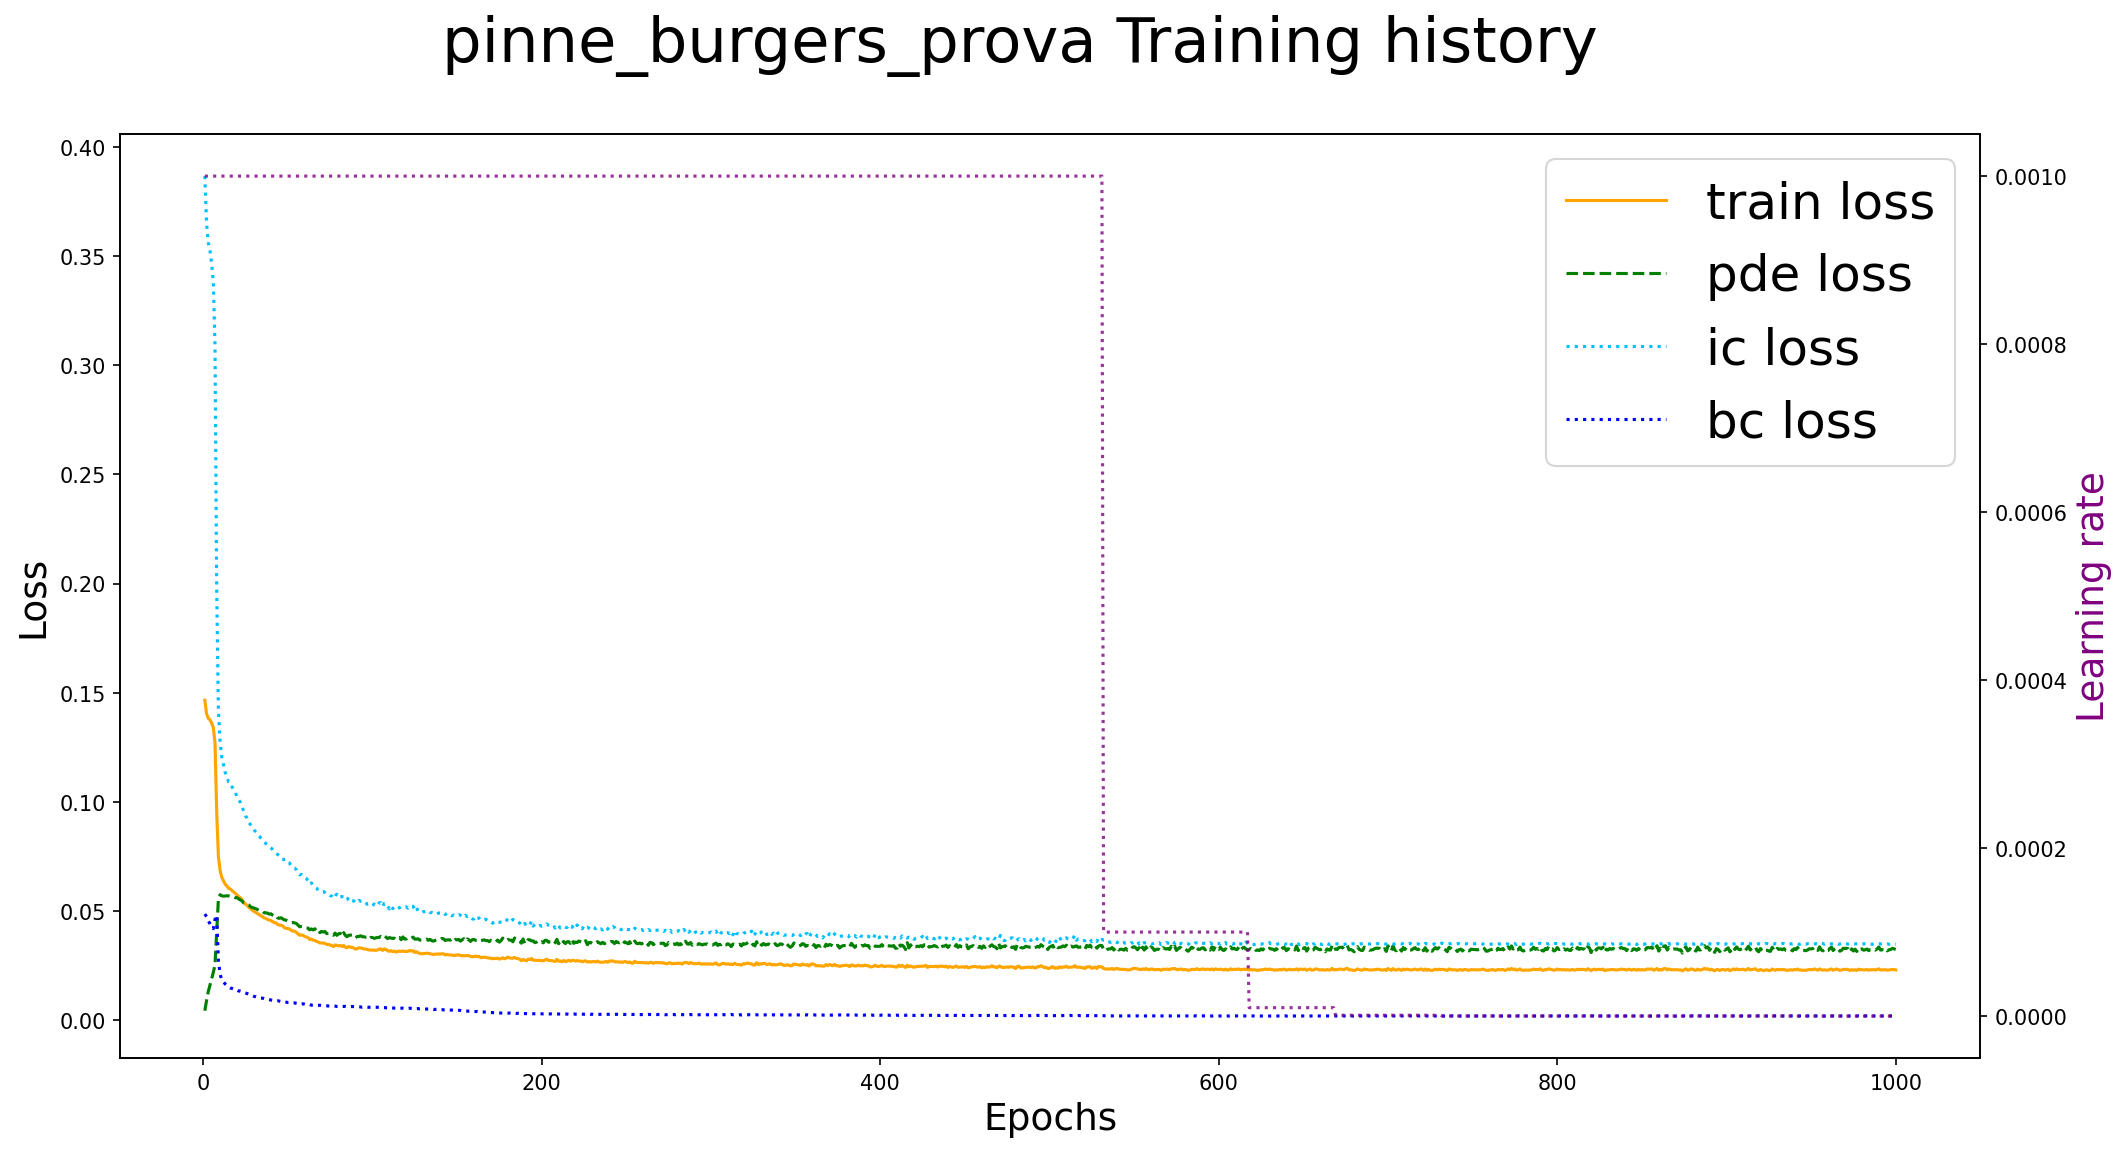

In [23]:
fig, ax = plt.subplots(figsize=(16, 8), dpi=150)
fig.suptitle(f"{pinn_model.model_name} Training history", fontsize=30)
ax.plot(range(1,len(pinn_model.training_loss)+1), pinn_model.training_loss, color='orange', linestyle='-', label='train loss')
# others
if pinn_model.use_rec:
    ax.plot(range(1,len(pinn_model.training_rec_loss)+1), pinn_model.training_rec_loss, color='red', linestyle='-.', label='rec loss')
ax.plot(range(1,len(pinn_model.training_pde_loss)+1), pinn_model.training_pde_loss, color='green', linestyle='--', label='pde loss')
ax.plot(range(1,len(pinn_model.training_ic_loss)+1), pinn_model.training_ic_loss, color='deepskyblue', linestyle=':', label='ic loss')
ax.plot(range(1,len(pinn_model.training_bc_loss)+1), pinn_model.training_bc_loss, color='blue', linestyle=':', label='bc loss')

ax.set_xlabel('Epochs',fontsize=18)
ax.set_ylabel('Loss',fontsize=18)

#ax.set_ylim(0.0, 0.9)

# plot LR
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(1,len(pinn_model.training_loss)+1), pinn_model.learning_rates, color='purple', linestyle=':', label='Learning rates', alpha=0.8)
ax2.set_ylabel("Learning rate", color="purple",fontsize=18)

ax.legend(fontsize=24)

fig.savefig(f"{pinn_model.BASE_PATH_TO_STORE}/{pinn_model.model_name}_training_history.pdf")

fig.show()

## 6. Test model

In [22]:
# load the best model
pinn_model.load_best_model()

Loaded best model: ./model_data/pinne_burgers_prova.pth at epoch: 873



In [ ]:
coords, ic_coords, bc_coords = pinn_model.generate_coords()
X = Variable(coords, requires_grad=True)
pred_func = pinn_model.forward(X.to(pinn_model.device) )#.cpu()

X_ic = Variable(ic_coords, requires_grad=True)
pred_func_ic = pinn_model.forward(X_ic.to(pinn_model.device) )#.cpu()

heat_pred = pinn_model.pde_loss(X, pred_func)

print(f"PDE loss: {heat_pred.item()}")

plt.figure(dpi=300)
coords = coords.detach().cpu()
plt.scatter(coords[:, 0], coords[:, 1], c=pred_func.squeeze(-1).detach().cpu(), s=1, cmap='jet')
ic_coords = ic_coords.detach().cpu()
plt.scatter(ic_coords[:, 0], ic_coords[:, 1], c=pred_func_ic.squeeze(-1).detach().cpu(), s=1, cmap='jet', vmin=0, vmax=1)
plt.show()

PDE loss: 0.03242604434490204


In [27]:
import scipy.interpolate

N_POINTS = 128

USE_SAME_SCALE = not True

# Grid data
t = np.linspace(pinn_model._t_min, pinn_model._t_max, N_POINTS)
x = np.linspace(pinn_model._x_min, pinn_model._x_max, N_POINTS)

T, X = np.meshgrid(t,x)

# Pred
coords = np.zeros([N_POINTS**2, 2])
coords[:, 0] = T.flatten()
coords[:, 1] = X.flatten()
X_VAR = Variable(torch.tensor(coords), requires_grad=True).float()
pred_functor = pinn_model.forward(X_VAR.to(pinn_model.device) )

pde_pred  = test_pde.compute_burgers(X_VAR, pred_functor)

pred_func = pred_functor.cpu().squeeze(-1).detach().numpy()
Z_false = pred_func.reshape(128, 128)

# PDE
pde_pred = pde_pred.cpu().squeeze(-1).detach().numpy()
Z_pde    = pde_pred.reshape(128, 128)


# ===== Figure ======
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=200, figsize=(18,8))
#and then comes the plot, with the colour-blind-friendly viridis colourmap

levels_pred = np.linspace(pred_func.min().item(), pred_func.max().item(), 75)
im0 = axs[0].contourf(
    T, X, Z_false,
    levels=levels if USE_SAME_SCALE else levels_pred,
    origin = 'lower',
    cmap='jet',
    alpha = 1.0
)
cbar0 = plt.colorbar(im0, ax=axs[0])
cbar0.set_label('u_f(x,t)')

#optional countour lines:
contours = axs[0].contour(T, X, Z_false, colors='yellow');
axs[0].clabel(contours, inline=True, fontsize=8)

axs[0].set_title(f"Predicted function for Burgers Eq. with nu={pinn_model.diffusion_coefficient:.3f}")
axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('x (m)')

# PDE
levels_pred_pde = np.linspace(pde_pred.min().item(), pde_pred.max().item(), 75)
im1 = axs[1].contourf(
    T, X, Z_pde,
    levels=levels if USE_SAME_SCALE else levels_pred,
    origin = 'lower',
    cmap='jet',
    alpha = 1.0
)
cbar1 = plt.colorbar(im1, ax=axs[1])
cbar1.set_label('PDE[u_f(x,t)]')

#optional countour lines:
contours1 = axs[1].contour(T, X, Z_pde, colors='yellow');
axs[1].clabel(contours1, inline=True, fontsize=8)

axs[1].set_title(f"PDE error for Burgers Eq. with nu={pinn_model.diffusion_coefficient:.3f}")
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('x (m)')

fig.savefig(f"{pinn_model.BASE_PATH_TO_STORE}/{pinn_model.model_name}_pred_func.pdf")

plt.show()

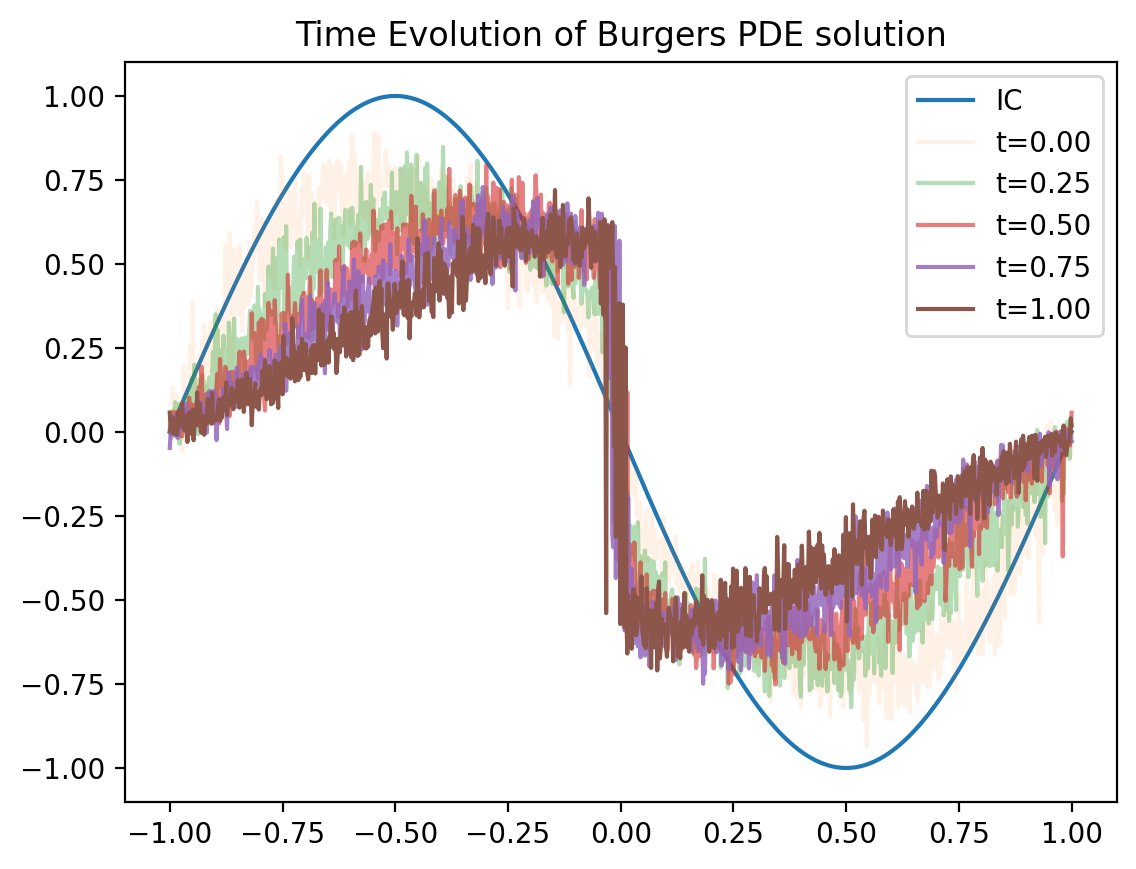

In [26]:
plt.figure(dpi=200)
N_POINTS = 1024

for t in np.arange(0.0, 1.25, 0.25):
    coords = np.ones([N_POINTS, 2])
    coords[:, 1]  = np.linspace(pinn_model._x_min, pinn_model._x_max, N_POINTS)
    coords[:, 0] *= t
    if t==0:
        plt.plot(coords[:, 1], - np.sin(np.pi*coords[:,1]), label=f"IC")
        
    X_VAR = Variable(torch.tensor(coords), requires_grad=True).float()
    pred_functor = pinn_model.forward(X_VAR.to(pinn_model.device) )
    pred_func = pred_functor.cpu().squeeze(-1).detach().numpy()
    
    plt.plot(coords[:, 1], pred_func, label=f"t={t:.2f}", alpha=min(t + 0.1,1))

plt.title("Time Evolution of Burgers PDE solution")
plt.legend()
plt.show()

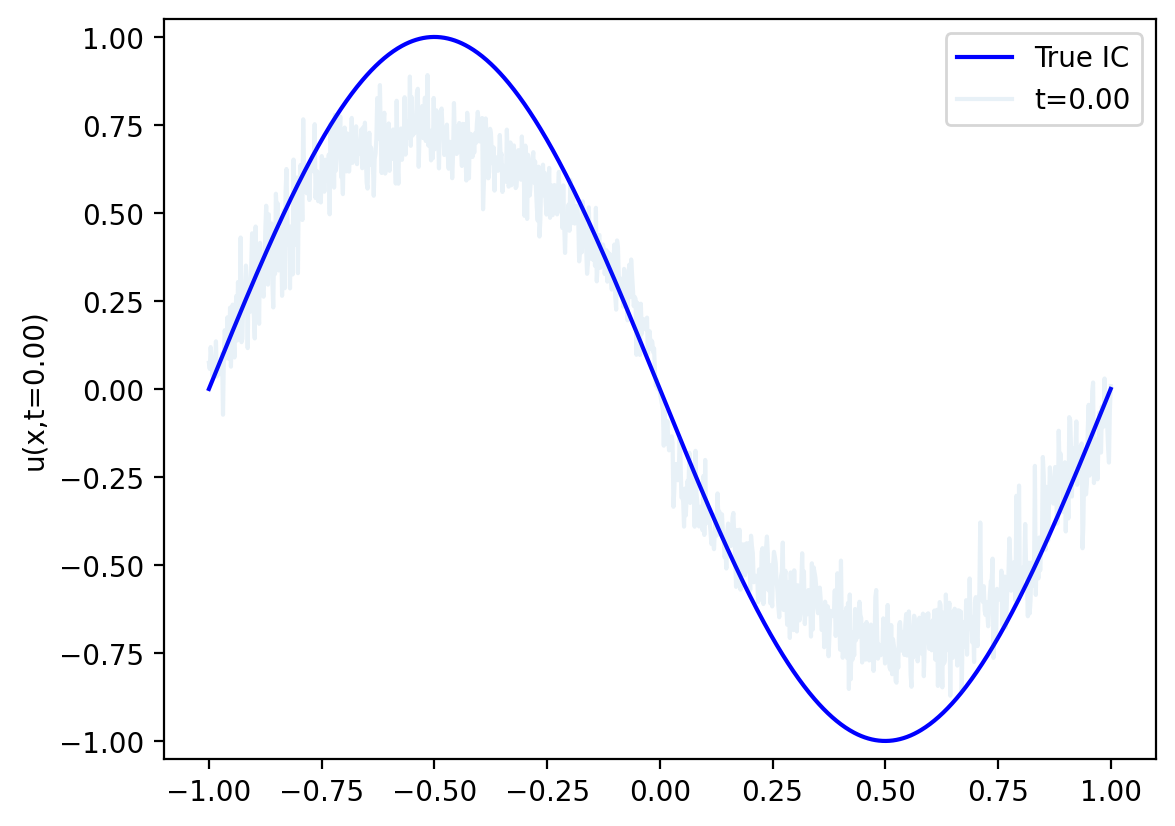

In [28]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1,1, dpi=200)
N_POINTS = 1024
ax.set_title("Time Evolution of Burgers PDE solution")
ax.set_xlabel('x')

num_steps = 20
_Delta = 1/num_steps

_time_range = np.arange(0.0, 1.0 + _Delta ,_Delta)
    

def update_plot(time_idx):
    ax.cla()
    t = _time_range[time_idx]
    coords = np.ones([N_POINTS, 2])
    coords[:, 1]  = np.linspace(pinn_model._x_min, pinn_model._x_max, N_POINTS)
    coords[:, 0] *= t
        
        
    X_VAR = Variable(torch.tensor(coords), requires_grad=True).float()
    pred_functor = pinn_model.forward(X_VAR.to(pinn_model.device) )
    pred_func = pred_functor.cpu().squeeze(-1).detach().numpy()
    
    ax.plot(coords[:, 1], - np.sin(np.pi*coords[:,1]), label=f"True IC", c='b')

    ax.plot(coords[:, 1], pred_func, label=f"t={t:.2f}", alpha=min(t + 0.1,1))
    ax.set_ylabel(f'u(x,t={t:.2f})')
    
    ax.set_ylim(bottom=-1.05, top=1.05)
    
    ax.legend()

ani = FuncAnimation(fig = fig, func = update_plot, frames = num_steps, interval = 100) 

In [29]:
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
4